In [1]:
import numpy as np 
import pyshtools as pysh #pyshtools is still necessary, even if i don't use the expend function (still need the legendre  polynome function)
import numpy.matlib as npmlib #used to add repmat 
from scipy import special as scsp
from scipy import io # !!!! check if it is still necessarry !!!!
from scipy import interpolate
from matplotlib import pyplot as plt # Matplotlib is not necessary at the begenning of the calculation may be load only in plot functions
import sys # used to access files
from tqdm import tqdm # used for the loading bars !!!! maybe unusefull since it is not supported with parallelized calculation !!!!
from multiprocessing import Pool,cpu_count,freeze_support # used for the multi processing calculation 
import itertools # same
import logging # Used to make the error message adapted to the code 
import math # calculation of sqrt
import time # time is only used for time evaluation
import par # used for the paralellization

Si il y a une erreur sur les modules : 

    - Faire clique droit --> new console for notebook
    - taper les commandes suivantes : 
        - conda install numpy
        - conda install matplotlib
        - conda install -c conda-forge pyshtools
    -Kernel --> restart kernel
    
Si un module est ajouté : conda env export -n <env-name>
    
Quand tu quitte l'env : ne pas oublier de saµuvegarder le dépôt vers Github ! (j'ai déjà perdu des données comme ça ^^) :
    -Enregistrer le fichier ! Selectionner le fichier, clique droit, download, puis push le fichier sur git. 
    

# Code to solve the elastic sea level equation following 

Kendall et al., 2005 and Austermann et al., 2015

J. Austermann 2015

Translated to Python and modified by A. Wickert, 2015

## Functions called in the main body

Functions used in the loop

In [2]:
def get_coeffs(a_lm,n):

    if n == 0 :
        a_n = a_lm[0]
    else :
        gauss_sum = int(n*(n+1)/2)
        # position of current order in a_lm vector
        a_n = a_lm[gauss_sum:gauss_sum+n+1]
    return a_n

def shtoolsconvertor(coeff):
    '''
    convert vector of spherical harmonic coefficient into a matrix of coefficient. 
    This new matrix is adaptated to data shape of shtools. 
         
        Parameters : 
            coeff (np.array): spherical harmonic vector of size !maxdeg.
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            Out (np.array): spherical harmonic array of size maxdeg, maxdeg ???? A vérifier
        
        Added fields : 
    '''
    l=coeff.shape[0] # get the length of the spherical harmonic coefficient vector
    maxdeg=int((-1+math.sqrt(1+8*l))/2) # calculate the maximum degree based on l 
    Out=np.zeros((maxdeg,maxdeg))+1j*0 # preset the size of the spherical harmonic coefficient matrix
    c=0 # preset the counter to 0 (python start from zero)
    for i in range(0,maxdeg): # run over the maximum degree 
        c=c+i # add the iteration to the counter, this way we jump to the other sequence of spherical harmonic (degree c+i)
        Out[i,:i+1]=coeff[c:c+i+1].squeeze() # set the matrix value for each ordr l to the value in the spherical harmonic coefficient vector
    return Out

def iconvertor(i):
    '''
    convert the indice i into two indices folowing the rule : i=j!+k with k<=j. j is the order and k is the degree. 
    
        Parameters : 
            i (int): the indices value
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            j (int): the degree indices
            k (int): the order indices
        
        Added fields : 
    '''
    j=0 # set the counter to 0 
    while i/(j+1)-j/2<0 or i/(j+1)-j/2>1 : # while j (the degree) is not between the two degree associated to the i ème coefficient of a spherical harmonic vector
        j+=1 # j advance of one
    k=i-j*(j+1)/2 # calculate the residual value between the jth degree and i to have the order
    if k>j: # if k is grester then j (not possible because the order must be between 0 and the degree)
        k=0 # the k become 0
        j+=1 # and we upgrade the degree of j by one
    return int(j),int(k) # because the output of these calculation are float and we need integers (indices). We convert the float to integer.

def love_lm(num,grid, group='m'):
  '''
    Exrtact from love numbers the h_lm spherical coefficient. 
    
        Parameters : 
            num (np.array): love number coefficient of the size of the entry file
            grid (object): output of the class GRID
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            h_lm (np.array): array of the love number transformed of size 1, maxdeg. 
        
        Added fields : 
  '''
  h=np.concatenate((np.zeros((1,1)),num)) # a 0 coefficient is added at the beginning of the love numbers !!!! WHY ? !!!!
  h_lm=np.array([]) # initialisation of the h_lm coefficient matrix
  for n in range (grid.maxdeg+1): # we work over the maxdeg + 1 degree !!!! I must understand why !!!! 
        h_add=npmlib.repmat(h[n],1,n+1) # reproduce the love number coefficient for n+1 time
        if h_lm.shape[0]==0 : # if ther is nothing in h_lm
            h_lm=h_add #set h_lm as h_add
        else : 
            h_lm= np.concatenate((h_lm,h_add),1) # add h_add to h_lm 
  return h_lm.transpose() # because the output is of the wrong shape we correct it by transposing the matrix

def get_tlm(maxdeg,earth, group='l'):
  '''
    Generate the T spherical harmonic coefficient. Retrouver d'où viennet ces coeff. 
    
        Parameters : 
            maxdeg (int): maximum degree of spherical harmonic defined in the model parameters. 
            earth (object): output of the class World_Model_Parameter. 
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            T_lm (np.array): array of size maxdeg + 1 
        
        Added fields : 
  '''
  T_lm=np.array([]) # preset the output
  T = np.zeros(maxdeg+1) # preset an array of the size maxdeg who will obtaine the coefficient and then be added to T_lm
  const = 4*np.pi*earth.a**3/earth.M_e # setting the tide constant for earth !!!! CHECK !!!!
  for n in range(maxdeg+1) :
        T[n]=const/(2*n+1) # for each nth add to T the earth constant moduladed by the nth step
        T_add=npmlib.repmat(T[n],1,n+1) # prepare T_add as the repetition of T
        if n==0 :
            T_lm=T_add # if there is nothing in T_lm preset T_lm as T_add
        else :
            T_lm=np.concatenate((T_lm,T_add),1) # else add T_add to T_lm
  return np.squeeze(T_lm) # we have to squeeze the array so that the requested indices are directly on the good axis

def calc_rot(L_in, love, earth):
  '''
  This function is actually unused but might be in the future. I didn't comment it right now
  '''
  # extract degree 2: 
  L20 = L_in[2,0]
  L21 = L_in[2,1] 
  L22 = L_in[2,2]
  k_L = love.k_el[1] # This has 256 values
  k_T = love.k_el_tide[1] # This has 256 values


  II = earth.sqrt_32_15 * np.pi * earth.a**4 * np.real(L21)-1j*earth.sqrt_32_15 * np.pi * earth.a**4 * np.imag(L21)

  # equation from Mitrovica and Wahr 2005

  m0 = II/earth.CminA * (1 + k_L) / ( 1 - (k_T/earth.k_hydro) )
  m1 = np.real(m0)
  m2 = np.imag(m0)
  m3 = 0

  m = np.hstack((m1, m2, m3))

  # calculate the perturbation to the rotational potential from Milne 1998
    
  La_out = np.zeros(L_in.shape)+1j*0

  La_out[0,0] = earth.a**2 * earth.omega**2/3 * (np.sum(m**2) + 2*m3)+1j*0
  La_out[2,0] = earth.a**2 * earth.omega**2/(6*5**.5) * (m1**2 + m2**2 - 2*m3**2 - 4*m3)+1j*0
  La_out[2,1] = earth.a**2 * earth.omega**2/30**.5 * (m1*(1+m3) - 1j*m2*(1+m3))
  La_out[2,2] = earth.a**2 * earth.omega**2/5**.5 * 24**.5 * ( (m2**2-m1**2) + 1j*2*m1*m2 )

  return La_out

def calc_rot_visc(SL, love, t_it,model_p):
  '''
    Update the object from the class spherical_sea_level the fields delLa, sdelI and sdelm.
    delLa are the spherical harmonic coefficient associated to the earth rotation.
    sdelI is the deformation of ice effect due to the rotation.
    sdelm is the deformation associated to the rotation. 
    
        Parameters : 
            SL (object): output of the class spherical_sea_level
            love (object): output of the class LOVE
            t_it (int): time step iteration
            model_p (object): output of the class World_Model_Parameter
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 
  '''
  # extract degree 2 coefficient from the load
  L00 = SL.delL[0]
  L20 = SL.delL[3]
  L21 = SL.delL[4] 
    
  C = model_p.C 
  # calculate the load effect constant 
  I1=math.sqrt(32/15)*math.pi*model_p.a**4*np.real(L21)
  I2=math.sqrt(32/15)*math.pi*model_p.a**4*np.imag(L21)
  I3=8/3*math.pi*model_p.a**4*(L00-L20/math.sqrt(5))
  I=np.array([I1,I2,I3])
  if t_it==1 : #initialise the rotational coefficient
        V_lm=np.array([0,0,0])
        V_lm_T=np.array([0,0,0])
  else : #apply the visco elastic properties of the earth on the rotation using the load.
    V_lm = np.dot(npmlib.expand_dims(love.beta_konly_l[t_it-1,:t_it-1],axis=1).transpose(),SL.sdelI[:,:t_it-1].transpose())[0]
    V_lm_T = np.dot(npmlib.expand_dims(love.beta_konly_tide[t_it-1,:t_it-1],axis=1).transpose(),SL.sdelm[:,:t_it-1].transpose())[0]
  temp = 1/(1-love.k_el_tide[1]/model_p.k_f)*(1/model_p.CminA * ((1+love.k_el[1])*I + V_lm) + V_lm_T/model_p.k_f)
  # calculate the perturbation to the rotational potential from Milne 1998
  m1=temp[0]
  m2=temp[1]
  temp = -1/(1-love.k_el_tide[1]/model_p.k_f)*(1/C * ((1+love.k_el[1])*I + V_lm))
  m3=temp[2]
  m=np.array([m1,m2,m3])
  # update the rotational load using.
  SL.sdelI[:,t_it] = I - np.sum(SL.sdelI[:,:t_it-1],1)
  SL.sdelm[:,t_it] = m - np.sum(SL.sdelm[:,:t_it-1],1)
  # calculate the rotational perturbation of the earth potential, just for the 6 first coefficient (no use to calculate further)
  SL.delLa = np.zeros(SL.delL.shape)+1j*0
  SL.delLa[0] = model_p.a**2 * model_p.omega**2/3 * (np.sum(m**2) + 2*m3)+1j*0
  SL.delLa[3] = model_p.a**2 * model_p.omega**2/(6*5**.5) * (m1**2 + m2**2 - 2*m3**2 - 4*m3)+1j*0
  SL.delLa[4] = model_p.a**2 * model_p.omega**2/30**.5 * (m1*(1+m3) - 1j*m2*(1+m3))
  SL.delLa[5] = model_p.a**2 * model_p.omega**2/5**.5 * 24**.5 * ( (m2**2-m1**2) + 1j*2*m1*m2 )

def calc_beta(self,grid) :
    '''
    Add to the object from the class LOVE the beta 
    coefficient used for the calculation of viscoelastic deformation 
    of earth. Two parameters are added : beta_tide and beta_konly_tide.
    
        Parameters : 
            self (object): output of the class LOVE
            grid (object): an output of the class GRID
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 
            beta_l (np.array) : a matrix of the beta coefficient with shape time_step, time_step, maxdeg+2. 
                                Where time_step is the number of time step defined in the GRID object and maxdeg is the maximum 
                                degree of spherical harmonic in the GRID object.
            beta_konly_l (np.array) : a matrix of the beta with only k coefficient with shape time_step, time_step, maxdeg+2. 
                                Where time_step is the number of time step defined in the GRID object and maxdeg is the maximum 
                                degree of spherical harmonic in the GRID object.
    '''
    maxdeg=grid.maxdeg # i'll must reduce the number of variable used 
    # initialize the output
    self.beta_l = np.zeros((len(grid.time_step)-1,len(grid.time_step)-1,maxdeg+1)) 
    self.beta_konly_l = np.zeros((len(grid.time_step)-1,len(grid.time_step)-1))
    for t_it in tqdm(range(1,len(grid.time_step)),"BETA"):  # loop on the time step
        #initialise the temporary variable for calculation use
        beta_l_int=self.beta_l[t_it-1]
        beta_konly_l_int=self.beta_konly_l[t_it-1]
        for n in range(1,t_it):
            # initialize the beta for each time step
            beta = np.zeros((maxdeg,)) 
            for lm in range(maxdeg):
                # num_mod is the number of love number needed for each degree-order
                num_mod = self.mode_found[lm][0] 
                # calculate the beta coefficient for each time step and degree-order
                beta[lm] = np.sum((self.k_amp[lm,:num_mod] - self.h_amp[lm,:num_mod])/self.spoles[lm,:num_mod] * (1 - np.exp(- self.spoles[lm,:num_mod]* (-grid.time_step[t_it] + grid.time_step[n]))))
            # add to the beta a coefficient of value 0 !!!!
            beta_l_int[n-1,:]=np.concatenate((np.array([0]),beta))
            # for rotation only needed for degree 2
            lm=1
            num_mod=self.mode_found[lm][0]
            # calculate the beta konly 
            beta_konly_l_int[n-1] = np.sum((self.k_amp[lm,:num_mod])/self.spoles[lm,:num_mod] * (1 - np.exp(- self.spoles[lm,:num_mod] * (-grid.time_step[t_it] + grid.time_step[n]))))
        #for each time step update the beta coeffcient
        self.beta_l[t_it-1]=beta_l_int
        self.beta_konly_l[t_it-1]=beta_konly_l_int
        
            
def calc_beta_tide(self,grid):
    '''
    Add to the object from the class LOVE the beta tide 
    coefficient used for the calculation of viscoelastic diformation 
    of earth. Two parameters are added : beta_tide and beta_konly_tide.
    
        Parameters : 
            self (object): output of the class LOVE
            grid (object): an output of the class GRID
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 
            beta_tide (np.array) : a matrix of the beta tide coefficient with shape time_step, time_step, maxdeg+2. 
                                Where time_step is the number of time step defined in the GRID object and maxdeg is the maximum 
                                degree of spherical harmonic in the GRID object.
            beta_konly_tide (np.array) : a matrix of the beta tide with only k coefficient with shape time_step, time_step, maxdeg+2. 
                                Where time_step is the number of time step defined in the GRID object and maxdeg is the maximum 
                                degree of spherical harmonic in the GRID object.
    '''
    maxdeg=grid.maxdeg 
    # initialize the beta coefficient of the love number
    self.beta_tide = np.zeros((len(grid.time_step)-1,len(grid.time_step)-1,maxdeg+1))
    self.beta_konly_tide = np.zeros((len(grid.time_step)-1,len(grid.time_step)-1))
    for t_it in tqdm(range(1,len(grid.time_step)),"BETA_TIDE"):
        beta_tide_int=self.beta_tide[t_it-1]
        beta_konly_tide_int=self.beta_konly_tide[t_it-1]
        for n in range(1,t_it):
            #initialize the beta coefficient at each time step time step for computational use
            beta = np.zeros((maxdeg,))
            for lm in range(maxdeg):
                num_mod = self.mode_found[lm][0]
                beta[lm]= sum((self.k_amp_tide[lm,:num_mod] - self.h_amp_tide[lm,:num_mod])/self.spoles[lm,:num_mod]* (1 - np.exp(- self.spoles[lm,:num_mod] * (-grid.time_step[t_it] + grid.time_step[n]))))
            beta_tide_int[n-1,:]=np.concatenate((np.array([0]),beta))
            lm=1
            num_mod=self.mode_found[lm][0]
            beta_konly_tide_int[n-1] = np.sum((self.k_amp_tide[lm,:num_mod])/self.spoles[lm,:num_mod] * (1 - np.exp(- self.spoles[lm,:num_mod] * (-grid.time_step[t_it] + grid.time_step[n]))))
        self.beta_tide[t_it-1]=beta_tide_int
        self.beta_konly_tide[t_it-1]=beta_konly_tide_int
        # for rotation only needed for degree 2

def calc_beta_counter(self):
    '''
    define the degree of the spherical harmonic for each beta coefficient 
    
        Parameters : 
            self (object): output of the class LOVE
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 
            beta_counter : np.array ((maxdeg+1)*(maxdeg+2)/2)
    '''
    self.beta_counter = np.ones(self.h.shape);
    l_it = 1;
    for lm_it in range(1,len(self.h)):
        # for each time step if the coefficient indices is one degree then , all the next values in beta_counter will have the previous of this one +1. litteraly the degree associated to there indices.
        if lm_it == l_it*(l_it+1)/2:
            self.beta_counter[lm_it] = self.beta_counter[lm_it-1]+1
            l_it = l_it+1
        else:
            self.beta_counter[lm_it] = self.beta_counter[lm_it-1]
            
def to_vector(coeff):
    '''
    convert matrix of spherical harmonic coefficient with the datashape of pyshtools to a vector. 
    
        Parameters : 
            coeff (np.array): a matrix of shape maxdeg , maxdeg ????? A vérifier
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            vect (np.array): a matrix of shape !maxdeg
        
        Added fields : 

    '''
    l=coeff.shape[0]
    vect=np.zeros((int((l*(l+1))/2),))
    c=0
    for i in range(l):
        for j in range(i):
            vect[c]=coeff[i,j]
            c+=1
    return vect
    
def to_grd(coeff):
    flm=np.array([np.real(coeff),np.imag(coeff)])
    Clm=pysh.shio.SHctor(flm)
    return np.real(pysh.SHCoeffs.from_array(Clm).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array())

def GaussQuad(N):
    '''
    Calculate the Gaussian grid parameters for the computation of the gaussian quadrature.
    
        Parameters : 
            N : int 
                The number of latitude in the grid. It's equal to the maximum degree
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 
            w (np.array): The weight of the node in the gaussian grid
            x (np.array):The nodes coefficient in the gaussian grid
    '''
    beta=0.5/np.sqrt(1-(2*np.linspace(1,N-1,N-1))**(-2))
    T=np.diag(beta,1)+np.diag(beta,-1)
    D,V=np.linalg.eig(T)
    x=D
    i=np.argsort(x)
    x=x[i]
    w=2*V[0,i]**2
    return x,w

def Legendre_generate(N):
    x,w=GaussQuad(N) # compute the parameter of the gaussian grid
    P_lm=[np.expand_dims(np.array([]),axis=0) for i in range(N+1)]# initialize the legendre polynôme !!!! calculer ces polynômes plutot que le faire chaque fois ira plus vite !!!!
    for l in range (N+1):
        # precalculate the normalization, like the Matlab code, we use the fully normalize version of the Legendre Polynôme
        m=np.linspace(0,l,l+1,dtype=int)
        c=np.expand_dims(((-1)**(l))*np.sqrt((l+1/2)*(scsp.factorial(l-m))/scsp.factorial(l+m)),axis=1)
        for i in range(len(x)):
            if i==0 : # if it's the first order of the degree we initialize the array
                #print('c',c.shape)
                #print('leg',np.expand_dims(pysh.legendre.legendre_lm(l,np.linspace(0,l,l+1,dtype=int),x[i],normalization='unnorm',csphase=-1),axis=1).shape)
                P_lm[l]=c*np.expand_dims(pysh.legendre.legendre_lm(l,np.linspace(0,l,l+1,dtype=int),x[len(x)-i-1],normalization='unnorm',csphase=-1),axis=1)
            else :
                P_lm[l]=np.concatenate((P_lm[l],c*np.expand_dims(pysh.legendre.legendre_lm(l,np.linspace(0,l,l+1,dtype=int),x[len(x)-i-1],normalization='unnorm',csphase=-1),axis=1)),axis=1) # use the pyshtools function to calclate the legendre polynôme
        #P_lm[l]=P_lm[l].transpose() # The output of concatenate is of the wrong shape so we transpose the P_lm
    return P_lm,w

Definition of the class used in the loop

In [145]:
############
#CLASS SPHERIC
############       

class sphericalobject(object):
    """
    A class difining any spherical object. This class is working with pyshtools.

    ...

    Attributes
    ----------
        grd : np.array (maxdeg,maxdeg x2)
           Value of the spherical object on a Gaussian Grid. 
        isgrd : Bool
           A boolean to define if a Gaussian grid have been defined for this object. 
        coeff : np.array (maxdeg,maxdeg) !!!! A vérifier !!!!
           Spherical harmonic coefficient array. 
        iscoeff : Bool
           A boolean to define if a spherical harmonic coefficient have been defined for this object.
        saved : np.array (n, maxdeg, maxdeg) !!!! A vérifier !!!! n is the number of time the save method is activated. 
           An array wich contain the spherical harmonic coefficient each time th save method is applied.
        prev : np.array (maxedg, maxdeg) !!!! A vérifier !!!!
           save the spherical coefficient using save_prev. 

    Methods
    -------
        grdtocoeff()
           Convert the Gaussian grid to spherical harmonic coefficient
        coefftogrd()
           Convert spherical harmonic coefficient to Gaussian grid
        multiply(flm2)
           Multiply the spherical coefficient of the object with the coefficient of flm2
        save_prev()
           Save the spherical harmonic coefficient to the attribute prev
        save()
           Save the spherical harmonic coefficient to the attribute saved and stack with previous saved coefficient
        modify(gc,t='grd')
           change the grid or coeff attribute with gc depending on t value    
    """
    
    def __init__(self,grd,t='grd'):
        """
        Parameters
        ----------
        grd : np.array
            array input a gaussian grid or spherical harmonic coefficient
        t : str
            value defining the type of the grd input, can be 'grd' or 'coeff' (default 'grd')
        """
        
        if t=='grd' : # initialize the grid if the entry is a grid
            self.grd=grd
            self.isgrd=True
            self.iscoeff=False
        elif t=='coeff': # initialize the coefficient if the entry is a coefficient
            self.coeff=grd
            self.isgrd=False
            self.iscoeff=True
        self.saved=np.array([]) # initialize the save of the spherical harmonic object
        
    def grdtocoeff(self):
        '''
    Convert a Gaussian grid into spherical harmonic coefficient array using a numerical method to create spherical harmonic coefficient
    self.coeff is updated usig these output.
    self.iscoeff defining if a coefficient have been created for this object. 
    If there is no grid created (self.isgrid == 0) then it returns an error.
    A modifier pour pouvoir modifier les entrées de la fonction.
    
        Parameters : 
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 

        '''
        if self.isgrd: # if there is a grid convert the gaussian grid to spherical coefficient.
            nlat,nlon=self.grd.shape # extract the shape of the grid
            P_lm,w=Legendre_generate(nlat)
            F_ym=np.fft.fft(self.grd,axis=1,norm='backward') # use the fourrier transform to sum over the exponential
            ind_a=0
            self.coeff=np.zeros((int((nlat+1)*(nlat+2)/2),))*1j # initialize the spherical harmonic coefficient vector
            for l in range(0,nlat+1): # calculate for all degree the spherical harmonic coefficient
                #if l==0 :
                #    c=np.sum(np.expand_dims(P_lm[l][l,:].transpose(),axis=1)*npmlib.repmat(w.transpose(),1,l+1).transpose()*np.expand_dims(F_ym[:,l],axis=1),axis=0,keepdims=True)
                #    self.coeff[0]=c[0,0]
                #else :
                #    self.coeff[ind_a:ind_a+l+1]=np.sum(P_lm[l][0:l+1,:].transpose()*npmlib.repmat(w.transpose(),l+1,1).transpose()*F_ym[:,0:l+1],axis=0,keepdims=True)
                #ind_a+=l
                self.coeff[ind_a:ind_a+l+1]=np.sum(P_lm[l][:l+1,:].transpose()*npmlib.repmat(np.expand_dims(w,axis=1),1,l+1)*F_ym[:,:l+1],axis=0)
                ind_a+=l+1
            # apply a coerrection to the coefficient
            self.coeff = self.coeff/(2*nlat)/math.sqrt(2)
            self.iscoeff=True # Set the spherical harmonic coefficient test to true.
        else : # else there is no grid and then return an error.
            logging.error('error: ', "No map created for this spherical object. Check if you have created the object with map or haven't run the coefftogrd() method")
            sys.exit(1)
        return self
                                                                           
    def grdtocoeff_shtools(self):
        '''
    Convert a Gaussian grid into spherical harmonic coefficient array using shtools.
    The output of pysh.SHGrid are converted to complex.
    self.coeff is updated usig these output.
    self.iscoeff defining if a coefficient have been created for this object. 
    If there is no grid created (self.isgrid == 0) then it returns an error.
    A modifier pour pouvoir modifier les entrées de la fonction.
    
        Parameters : 
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 

        '''
        if self.isgrd: # if there is a grid convert the gaussian grid to spherical coefficient.
            CSlm=pysh.SHGrid.from_array(self.grd,'GLQ').expand(normalization='4pi', csphase=1, lmax_calc=None, backend=None, nthreads=0).to_array()# use pyshtools to convert to convert the grd to spherical harmonic coefficient.
            flm=pysh.shio.SHrtoc(CSlm)
            self.iscoeff=True
            self.coeff=flm[0,:,:]+1j*flm[1,:,:]# Transform the two part of the spherical coefficient into a single array with an imaginary part. !!!! check the name of the coefficient !!!!
        else : # else there is no grid and then return an error.
            logging.error('error: ', "No map created for this spherical object. Check if you have created the object with map or haven't run the coefftogrd() method")
            sys.exit(1)
        return self
                                                                                  
    def coefftogrd(self):
        '''
    Convert spherical harmonic coefficient into a gird array using shtools.
    The output of pysh.SHCoeff are converted to real.
    self.grd is updated usig these output.
    self.isgrd defining if a grid have been created for this object. 
    If there is no grid created (self.iscoeff == 0) then it returns an error.
    A modifier pour pouvoir modifier les entrées de la fonction.
    
        Parameters : 
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 

        '''
        if self.iscoeff :# if there is spherical coefficient convert the spherical coefficient to a gaussian grid.
            m=self.coeff.shape[0]
            N=int((math.sqrt(1+8*m)-1)/2-1) 
            P_lm,w=Legendre_generate(N)
            F_ym=np.zeros((N,N*2))*1j
            for l in range(N+1):
                F_ym[:,:l+1] = F_ym[:,:l+1] + P_lm[l][:l+1,:].transpose()*npmlib.repmat(get_coeffs(self.coeff,l),N,1)
            F_ym[:,N+1:] = np.conj(F_ym[:,N-1:0:-1]) 
            F_yx = np.fft.ifft(F_ym,axis=1,norm='backward') 
            self.grd = F_yx*(2*N)*math.sqrt(2)
            self.grd=np.real(self.grd)
            self.isgrd=True 
        else : # else there is no coefficient and then return an error.
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
        
    def coefftogrd_pyshtools(self):
        '''
    Convert spherical harmonic coefficient into a gird array using shtools.
    The output of pysh.SHCoeff are converted to real.
    self.grd is updated usig these output.
    self.isgrd defining if a grid have been created for this object. 
    If there is no grid created (self.iscoeff == 0) then it returns an error.
    A modifier pour pouvoir modifier les entrées de la fonction.
    
        Parameters : 
            
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
        
        Added fields : 

        '''
        if self.iscoeff :# if there is spherical coefficient convert the spherical coefficient to a gaussian grid.
            flm=np.array([np.real(self.coeff),np.imag(self.coeff)]) # Convert the imaginary array to the two part of the spherical coefficient. 
            Clm=pysh.shio.SHctor(flm)# use pyshtools to convert the spherical coefficient array into a gaussian grid.
            self.grd=np.real(pysh.SHCoeffs.from_array(Clm).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array())
        else : # else there is no coefficient and then return an error.
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def multiply(self,flm2):
        '''
    This function is no longer used !!!!    
    
    Multiply the spherical coefficient of a gird with the others. It could be done using the pysh.SHcoeffs.Multiply.
    I choose to do it manually but i could test the efficiency of the pysh tool function. 
    
        Parameters : 
            flm2 (np.array): the harmonic coefficient matrix of size maxdeg, maxdeg !!!! A vérifier !!!!!
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            flm[0,:,:]+1j*flm[1,:,:] (np.array): the harmonic coefficient matrix resulting of the multiplication of the two grids. 
            size maxdeg, maxdeg !!!! A vérifier !!!!
            
        Added fields : 

        '''
        # convert two spherical coefficient into gaussian grid.
        flm1=np.array([np.real(self.coeff),np.imag(self.coeff)])# for the object
        Clm1=pysh.shio.SHctor(flm1)
        flm2=np.array([np.real(flm2),np.imag(flm2)])# for the matrix in entry
        Clm2=pysh.shio.SHctor(flm2)
        grd1=pysh.SHCoeffs.from_array(Clm1).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array()
        grd2=pysh.SHCoeffs.from_array(Clm2).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array()                                         
        grd=grd1*grd2 # multiply the two grids.
        # reconvert the resulting gaussian grid into spherical harmonic coefficient using pyshtools.
        Clm=pysh.SHGrid.from_array(grd,'GLQ').expand(normalization='4pi', csphase=1, lmax_calc=None, backend=None, nthreads=0).to_array()
        flm= pysh.shio.SHrtoc(Clm)
        return flm[0,:,:]+1j*flm[1,:,:]
    
    def save_prev(self):
        '''
    Create a new field for the object to save the spherical coefficient at the moment of the applied function. 
    This function make a clean copy of the array to avoid modification. 
    
        Parameters : 
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            
        Added fields : 
            prev (np.array): a copy of the self.coeff spherical coeffcient matrix of size maxdeg, maxdeg !!!! A vérifier !!!!

        '''
        if self.iscoeff : # if there is spherical coefficient for this object copy these coefficient to self.prev
            self.prev=self.coeff.copy()
        else : # else retrun an error
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def save(self):  
        '''
    Create a 3D matrix containing the spherical coefficient of each time this function is activated or add a copy of the
    spherical coefficient to the already existing matrix.
    
        Parameters : 
            flm2 (np.array): the harmonic coefficient matrix of size maxdeg, maxdeg !!!! A vérifier !!!!!
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns : 
            flm[0,:,:]+1j*flm[1,:,:] (np.array): the harmonic coefficient matrix resulting of the multiplication of the two grids. 
            size maxdeg, maxdeg !!!! A vérifier !!!!
            
        Added fields : 

        '''
        if self.iscoeff : # if there is spherical coeffcient created
            if self.saved.shape[0]==0: # if the matrix don't exist create one
                self.saved=np.array([self.coeff])
            else : # else add to the matrix the spherical coefficient of the object
                self.saved=np.concatenate((self.saved,np.array([self.coeff.copy()])),axis=0)
        else : # else retrun an error
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def modify(self,gc,t='grd'):
        '''
    Modify the coeff or grid field of the object depending on the t variable. 
    Default value for t is grd. 
    
        Parameters : 
            gc (np.array): spherical coefficient matrix of size maxdeg, maxdeg !!!! A vérifier !!!! or
                           Gaussian grid of the data of size maxdeg, maxdegx2. 
            t (str): string value to set the type of the gc entry. 'grd' for grid, 'coeff' for spherical coefficient.
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            grd (np.array): array of size maxdeg, maxdeg. !!!! A vérifier !!!!
            coeff (np.array): array of spherical coefficient of size maxdeg,maxdeg. !!!! A vérifier !!!!
            iscoeff (bool): boolean value, true if there is a coefficient false otherwise
            isgrd (bool): boolean value, true if there is a grid false otherwise

        '''
        if t=='grd':# if t is 'grd' modify self.grd with gc and update the iscoeff and isgrd field to false and true respectively.
            self.grd=gc
            self.iscoeff=False
            self.isgrd=True
        elif t=='coeff': # if t is 'coeff' modify self.coeff with gc and update the iscoeff and isgrd field to true and false respectively.
            self.coeff=gc
            self.isgrd=False
            self.iscoeff=True
        else : # else there is no recgnize value of t and then return an error.
            logging.error('error: ', "Wrong entry for t parameter. Verify the entry is 'grd' or 'coeff'.")
            sys.exit(1)
        return self
    
                
    
#########
#CLASS OCEAN
#########

class spherical_ocean_function(sphericalobject):
    """
    A class used to represent the ocean grid

    ...

    Attributes
    ----------
        rho : float
           Density value of the water
        oc_0_grd : np.array (maxdeg, maxdeg x2)
           Gaussian grid with 0 or 1 copy of the ocean function at time 0 normaly. 
        oc_0_coeff : np.array (maxdeg, maxdeg) !!!! A vérifier !!!! 
           spherical harmonic coefficient copy of the ocean function at time 0 normaly
    Methods
    -------
        update_oc_0()
            set the oc_0_grd and oc_0_coeff attribute as a copy of the grd and coeff
        evaluate_ocean(topo)
            evaluate the ocean function based on the Gaussian grid of the topography topo
    """
    def __init__(self) :
        """
        Parameters
        ----------
        """
        # initialize the ocean with no grid and no coefficient. The saved is also initialized. The volumetric mass of water is set to 1000 
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        self.rho=1000.
        
    def update_oc_0(self):
        '''
        Update the oc_0_grd and oc_0_coeff fields with the coeff and grd fields of the object. For the initialization of ocean function in the code
    
        Parameters : 
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            oc_0_grd (np.array): array of a gaussian grid of size  maxdeg, maxdeg x2.
            oc_0_coeff (np.array): array of the spherical coefficient of size maxdeg,maxdeg !!!! A vérifier !!!!.

        '''
        # The two types of data are used from oc_0 so we create the two of them.
        self.oc_0_grd=self.grd.copy()
        self.oc_0_coeff=self.coeff.copy()
        
    def evaluate_ocean(self,topo) :
        '''
        
        Evaluate the ocean function using the topography. It create a 0-1 matrix wich is 1 where topo<0 and 0 where topo>0.  
    
        Parameters : 
            topo (np.array): topo gaussian grid of size maxdeg, maxdegx2
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            self.grd (np.array): a matrix of 0 and 1 with shape maxdeg, maxeg x 2.

        '''
        # use sign function to optimize the conversion from positive negative value to boolean value.
        out = -0.5*np.sign(topo)+0.5
        out = 0.5*np.sign(out-0.6)+0.5
        # set the grd to the output of the previous computation.
        self.grd=out
        self.isgrd=True
        return self

###########
#CLASS SED
###########
    
class spherical_sed(sphericalobject):
    """
    A class used to represent the sediment grid

    ...

    Attributes
    ----------
        rho : float
           Density value of the sediment as a constant
        sed : np.array (maxdeg, maxdeg x2)
           Gaussian grid with the sediment thickness
    Methods
    -------
        load(grid)
            load the sediment grid, it actually just create a grid of 0.
        calc_del_sed(t_it)
            calculate the sediment thickness deposited between the time step t_it, t_it+1
    """
    def __init__(self) : 
        """
        Parameters
        ----------
        """
        # preset the grid and coefficient to none. The sediment density is set to 2300 
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        self.rho = 2300.
    
    def load(self,grid):
        '''
        function to load the sediment grid. The actual version simply create a matrix of 0.
    
        Parameters : 
            grid (object): The output of the class GRID. 
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            sed (np.array): the sediment thickness threw time the shape is number of time step, maxdeg, maxdegx2
                            The definition here is the one of Mitrovica code. 
                            So the thickness of sediment at time is the thickness deposited from that time till present.

        '''
        self.sed=np.zeros((len(grid.time_step),grid.nlats,grid.nlons)) # create a matrix of 0 for the sediment thicness
        self.isgrd=True # set the value of grid to true. 
        return self
        
    def calc_del_sed(self,t_it) :
        '''
        Calculate the sediment thickness variation between the time step t_it and the bigining of the modelisation. 
    
        Parameters : 
            grid (object): The output of the class GRID. 
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            grd (np.array): the grd matrix of shape maxdeg, maxdeg x2 of sediment thickness.

        '''
        self.grd=self.sed[t_it,:,:]-self.sed[0,:,:] # calculate the difference between actual sediment thickness and the one at t_it
        self.isgrd=True # because a grid was created, update the isgrd parameter.
        return self
    
############
#CLASS ICE
############

class spherical_ice(sphericalobject):
    """
    A class used to represent the ice grid

    ...

    Attributes
    ----------
        rho : float
           Density value of the ice
        ice : np.array (nb_time_step, maxdeg, maxdeg x2)
           Ice thickness Gaussian grid
        ice_corrected : np.array (np_time_step, maxdeg, maxdeg x2)
           Ice thickness Gaussian grid corrected of the crusted ice
        
    Methods
    -------
        load(grid)
           load the ice from ice_6g model  !!! need to be modified !!!
        quickload(grid)
           load the ice from ice_6g model and is parallelized  !!! need to be modified !!!
        calc_del_ice(t_it)
           update the grd field with the variation of ice thickness
        
    """
    def __init__(self) : 
        """
        Parameters
        ----------
        """
        # initialize to false the grid and coefficient (no grid or coefficient pre loaded). The ice volumetric masse is set to 916.7 kg/m3.
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        self.rho=916.7
        
    def load(self,grid):
        '''
        
        Function to load the ice data from the ice6g map. 
        I'll have to create a function to simply interpolate a time grid for ice.
        This way anyone can load a data without having to modify or create a function. 
        
        Parameters :  
            grid (object): Output of the class GRID.
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            ice (np.array): The ice thickness threw time matrix interpolated on the Gaussian grid of GRID class of shape time step, maxdeg, maxdeg x 2.
            ice_corrected (np.array): an array full of zero with the same shape then the ice field. 
        ''' 
        data=io.loadmat('ice6g_data') #load the file, can be modified to load an other file.
        ice_in=data['ice6g']
        ice_time=data['ice_time']
        ice_time=ice_time[0]
        grid.time_step=np.zeros(ice_time.shape)# using the ice time format to set the variable. It could be interesting to set the time vairable from an other parameters.
        self.ice=np.zeros((len(grid.time_step),grid.nlats,grid.nlons)) # precreate the ice matrix. 
        # same for the ice_corrected matrix. 
        #create an enlarged ice_lat and ice_long matrix
        ice_lat=np.zeros((data['ice_lat'].shape[0]+2,1)) 
        ice_long=np.zeros((data['ice_long'].shape[0]+2,1))
        ice_lat[0],ice_lat[-1],ice_lat[1:-1] =90,-90,data['ice_lat']
        ice_long[0],ice_long[-1],ice_long[1:-1] =-0.5,360.5,data['ice_long']
        # do the same thing with ice_extended
        # for each time step interpolate the ice grid on the Gaussian grid defined in GRID class
        for t_it in tqdm(range(len(grid.time_step)),"ICE"):
            ice_nointerp=ice_in[t_it]
            ice_extended=np.concatenate((np.zeros((1,len(ice_long)-2)),ice_nointerp,ice_nointerp[0,-1]*np.ones((1,len(ice_long)-2))),axis=0)
            ice_extended_2=np.concatenate((np.expand_dims(ice_extended[:,-1],axis=1),ice_extended,np.expand_dims(ice_extended[:,0],axis=1)),axis=1)

            ice_interp = grid.interp_on(ice_extended_2,ice_long,ice_lat)
            
            time.sleep(0.01)
            self.ice[len(grid.time_step)-t_it-1,:,:] = ice_interp
            grid.time_step[t_it] = ice_time[len(ice_time)-t_it-1]
        
    def quick_load(self,grid):
        '''
        
        Function to load the ice data from the ice6g map. 
        This version was parallelized to accelerate the loading of the model.
        I'll have to create a function to simply interpolate a time grid for ice.
        This way anyone can load a data without having to modify or create a function. 
        
        Parameters :  
            grid (object): Output of the class GRID.
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            ice (np.array): The ice thickness threw time matrix interpolated on the Gaussian grid of GRID class of shape time step, maxdeg, maxdeg x 2.
            ice_corrected (np.array): an array full of zero with the same shape then the ice field. 
        ''' 
        data=io.loadmat('ice6g_data')#load the file, can be modified to load an other file.
        ice_in=data['ice6g']
        grid.time_step=data['ice_time']
        grid.time_step=grid.time_step[0]
        ice_time=grid.time_step.copy()# using the ice time format to set the variable. It could be interesting to set the time vairable from an other parameters.
        self.ice=np.zeros((len(grid.time_step),grid.nlats,grid.nlons))  # precreate the ice matrix.
        self.ice_corrected=self.ice # same for the ice_corrected matrix.
        #create an enlarged ice_lat and ice_long matrix
        ice_lat=np.zeros((data['ice_lat'].shape[0]+3,1))
        ice_long=np.zeros((data['ice_long'].shape[0]+3,1))
        ice_lat[0],ice_lat[-1],ice_lat[1:-2] =90,-90,data['ice_lat']
        ice_long[0],ice_long[-1],ice_long[1:-2] =-0.5,-360.5,data['ice_long']
        # do the same thing with ice_extended
        ice_extended=np.zeros((ice_in.shape[1]+3,ice_in.shape[2]))
        ice_extended_2=np.zeros((ice_in.shape[1]+3,ice_in.shape[2]+3))
        # for each time step interpolate the ice grid on the Gaussian grid defined in GRID class
        # In this version i created a function called par.py wich isa parallelised version of the for loop of the upper version. 
        # It need to define a pool object to precharge the core calculator.
        workers = int(cpu_count()/2)# half of the core are used by the code.
        pool = Pool(workers)
        pbar = tqdm(total=len(ice_time),desc="ICE")# set the bar (it don't work really well).
        results=pool.starmap(par.f_ice_quick_load,zip(itertools.repeat(ice_time),itertools.repeat(ice_extended),itertools.repeat(ice_extended_2),ice_in,range(len(ice_time)),itertools.repeat(ice_long),itertools.repeat(ice_lat),itertools.repeat(grid.lats),itertools.repeat(grid.elons)))
        self.ice=np.array([results[i][0] for i in range(len(results))])
        grid.time_step=np.array([results[i][1] for i in range(len(results))])
        pbar.update(len(ice_time))
        
    def calc_del_ice(self,t_it) :# avec ça deli seras près définit et prev doit être calculer
        '''
        
        Calculate the variation of ice thickness between the biggiinig of the modelisation until the time step t_it. 
        
        Parameters :  
             t_it (int): The indices of the time step.
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            grd : A gaussian grid of the ice thickness variation at t_it, with the whape maxdeg, maxdeg x 2. 
        
        ''' 
        self.grd=self.ice_corrected[t_it,:,:]-self.ice_corrected[0,:,:] # calculate the difference of ice thickness between actual and the one at t_it.
        self.isgrd=True
        return self
        
#################
#CLASS TOPO
#################
        
class spherical_topo(sphericalobject):
    """
    A class used to represent the topographic grid

    ...

    Attributes
    ----------
        topo_pres : np.array (maxdeg, maxdeg x2)
            The present topography gaussian grid
        topo_initial : np.array (maxdeg, maxdeg x2)
            The topography at the begining of the modelization (maxdeg, maxdeg x2)
        topo : np.array (n_time_step, maxdeg, maxdeg x2)
            The topography threw time
        topo_0 : np.array (maxdeg, maxdeg x2)
            Gaussian grid of the topography at the time of run update_topo_0. Used to save the initial topography after it's modification by the load. 

    Methods
    -------
        load(grid,,ice,sed)
            Load the topographic data from the file topo_SL. Create the topography variation by including the ice thickness and the sediment thickness
        update_topo_0()
            update the topo_0 attribute.
        ice_correction(ice,grid,oc)
            correct the ice and the topography from the land attached ice variation.          

    """
    def __init__(self) : 
        """
        Parameters
        ----------
        """
        # initialize coefficient and grid to 0 because no grid or coefficient has been created
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        
    def load(self,grid,ice):
        '''
        Load the topography and adapt it with the ice and sediment thickness.
        
        Parameters :  
            grid (object): output of the class GRID
            ice (object): output of the class spherical_ice
            sed (object): output of the class spherical_sed
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            topo_pres (np.array): matrix of the present topography with shape maxdeg, maxdeg x 2. This grid is 
                                  defined to compare with the topography at the end of the simulation.
            topo_initial (np.array): matrix of the topography at the begining of the modelisation, with shape maxdeg, maxdeg x 2.
            topo (np.array):matrix of the topography threw time with shape time step, maxdeg, maxdeg x 2.
            grd (np.array): graussian grid set to the topography at the beginning of the simulation, maxdeg, maxdeg x 2.
        
        '''
        data=io.loadmat('topo_SL') # load the topographic data from topo_SL
        self.topo_pres=grid.interp_on(data['topo_bed'],np.transpose(data['lon_topo'][0]),np.transpose(data['lat_topo'][0]))+ice.ice[-1,:,:] 
        #self.topo_initial = self.topo_pres - ice.ice[-1,:,:] - sed.sed[-1,:,:] + ice.ice[0,:,:] + sed.sed[0,:,:]
        #self.topo=np.zeros((len(grid.time_step),self.topo_initial.shape[0],self.topo_initial.shape[1]))
        # interpolate the topographic grid over space for each time step. 
        #for t_it in tqdm(range(1,len(grid.time_step)),"TOPO"): 
        #    self.topo[t_it,:,:]=self.topo_pres - ice.ice[-1,:,:] ;
        #    time.sleep(0.001)
        #self.topo[0,:,:]=self.topo_pres # set the topography at time 0 to the present topography.
        #self.grd=self.topo[0,:,:] # preset the grd obect to the topography at the beginning of the modelisation.
        return self
    
    def update_topo_0(self):
        '''
        update the topography 0 wich is the topography at the beginning of the simulation. This function is used to update
        the initial topography after each simulation to restart a loop over it. This way there is a convergence and we take in account the GIA.
        
        Parameters :  
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            topo_0 (np.array): A matrix of the topography at the bigining of the simulation of shape maxdeg, maxdeg x 2.  
        '''
        self.topo_0=self.topo[0,:,:].copy() # update the actual topography 
        return self
    
    def ice_correction(self,ice,grid,oc):
        '''
        A function to correct the variation of crusted ice due to the variation of the topography. 
        This function use the ocean function generated by the ice thickness minus topography, topography minus ice thickness and
        the ice load plus the crusted ice. 
        
        Parameters :  
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            topo (array): the topography matrix threw time with shape time_step, maxdeg, maxdeg x 2.
            ice_corrected (array): the ice corrected from crusted ice matrix of shape time_step, maxdeg, maxdeg x 2
        
        '''
        # apply the correction for each time step
        for t_it in range(len(grid.time_step)):
            self.topo[t_it,:,:]=self.topo[t_it,:,:]-ice.ice_corrected[t_it,:,:]+ice.ice[t_it,:,:]
        for t_it in range(len(grid.time_step)): # to parallelize
            check1 = spherical_ocean_function().evaluate_ocean(-self.topo[t_it,:,:]+ice.ice[t_it,:,:]) # generate the ocean function for ice-topo
            check2 = spherical_ocean_function().evaluate_ocean(self.topo[t_it,:,:]-ice.ice[t_it,:,:]).grd*(spherical_ocean_function().evaluate_ocean(-ice.ice[t_it,:,:]*ice.rho-(self.topo[t_it,:,:]-ice.ice[t_it,:,:])*oc.rho).grd)
            ice.ice_corrected[t_it,:,:] = check1.grd*ice.ice[t_it,:,:]+check2*ice.ice[t_it,:,:] # add the two part of ice over the check1 nd check2 positive area.
        for t_it in range(len(grid.time_step)):    
            self.topo[t_it,:,:]=self.topo[t_it,:,:]+ice.ice_corrected[t_it,:,:]-ice.ice[t_it,:,:]
         # apply the correction to the topography.
            #plt.pcolor(self.topo[t_it,:,:])
            #plt.colorbar()
            #plt.show() 
            
            
############
#CLASS SEA LEVEL
############

class spherical_sea_level(object):
    """
    A class used to represent the sea level spherical harmonic coefficient component.

    ...

    Attributes
    ----------
        del_L : np.array (maxdeg, maxdeg x2)
            Variation between the actual and past load on earth resulting from the redistribution of sediment ice thickness variation and geoid shpe modification. 
        
        del_L_prev : object (class sphericalobject)
            Previous variation between the actual and past load on earth resulting from the redistribution of sediment ice thickness variation and geoid shpe modification.
        
        TO : object (class sphericalobject)
            Variation of the topography between the ocean borders of two time step.
        
        sdelS : np.array (maxdeg, maxdeg x2)
            Variation of the sea level between two time step.
        
        sdelL : np.array (n_time_step, maxedg+1, maxdeg+1)
            Variation of the load at between the two time step
             
        delLa : np.array (n_time_step, maxedg+1, maxdeg+1)
            !!!! Je n'arrive pas à savoir ce que c'est !!!!
        
        delLa_prev : np.array (n_time_step, maxedg+1, maxdeg+1) !!!! A vérifier !!!!
            !!!! Pareil, ça dépend de la même chose, c'est le précedant mais à un time step de moins !!!! 
        
        sdelLa_prev : np.array (n_time_step,maxedg+1, maxdeg+1)
            !!!! Pareil , mais c'est la variation entre deux time step !!!!
        
        delSLcurl_fl : 
        
        delSLcurl : object (from class spherical object)
        
        RO : np.array (maxdeg, maxdeg)
            Ocean elevation on ocean (the geoïd cut by the ocean function)
        
        sdelS_new : np.array (maxdeg+1,maxdeg+1)
            The new geoïd created to calculated the convergence creterion. 
        
        delSL : np.array (maxdeg+1, maxdeg+1)
            The variation of the geoïd between actual and past. 
        
        saved : np.array (n, maxdeg, maxdeg) with n the number of time the save method is activated.
            The saved parameters as defined in the function. 
        
    Methods
    -------
        save(grid)
            Save a parameter each time the function is used and stack it with the others. 
                     

    """
    
    def __init__(self,grid):
        """
        Parameters
        ----------
        grid : object (object from class GRID)
        """
        self.delL=0 #: coeff
        self.delL_prev=0
        self.TO=sphericalobject(np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))) #: coeff mais créer avec des grids
        self.sdelS=0 #: coeff
        self.delS=0 #: coeff
        self.sdelL=np.zeros((len(grid.time_step),int((grid.maxdeg+1)*(grid.maxdeg+2)/2)))+1j*0 #: coeff
        self.delLa=np.zeros((len(grid.time_step),int((grid.maxdeg+1)*(grid.maxdeg+2)/2)))+1j*0 #: coeff
        self.delLa_prev=0
        self.sdelLa=np.zeros((len(grid.time_step),int((grid.maxdeg+1)*(grid.maxdeg+2)/2)))+1j*0#: coeff
        self.delSLcurl_fl=0 #: coeff
        self.delSLcurl=sphericalobject(np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),)))#: coeff
        self.RO=sphericalobject(np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))) 
        self.sdelS_new=0
        self.delSL=sphericalobject(np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),)))
        self.saved=np.array([])
        
    def save(self): # is it still usefull ? Check in code
        if self.saved.shape[0]==0:
            self.saved=np.array([self.sdelI])
        else :
            self.saved=np.concatenate((self.saved,np.array([self.sdelI.copy()])),axis=0)
        return self
    
############
#CLASS GRID
############

class GRID(object):
        """
    A class used to represent the Gaussian Grid

    ...

    Attributes
    ----------
        model_p : Object (from class World_Model_Parameter)
            model parameter used as entry to create the grid
        maxdeg : int
            maximum degree of the spherical harmonic used in the model !!!! peut être ne pas reproduire les constante au travers de objets !!!! 
        nlons : int
            number of longitude in the grid
        nlats : int
            number of latitude in the grid
        lats : np.array (maxdeg, maxdeg x2)
            latitude as a meshgrid
        elons : np.array (maxdeg, maxdeg x2)
            longitude as a meshgrid
        colats : np.array (maxdeg, maxdeg x2)
            colatitude as a meshgrid
        time_step : np.array(nb_time_step)
            value of the different time step used in the model.
    Methods
    -------
        add_time(time_step)
        interp_on(grd,lon,lat)
        create_ICE()
        create_SED()
        create_TOPO()
        create_LOVE()
        create_SL()
                     

        """
        def __init__(self,model_p):
            """
            Parameters
            ----------
            model_p : object (object from class World_Model_Parameter)
            """
            self.model_p=model_p
            self.maxdeg=model_p.maxdeg # maybe no use of defining the maximum degree here ofr in model_p
            self.nlons = (self.maxdeg) * 2 
            self.nlats = (self.maxdeg)
            x,w=GaussQuad(self.maxdeg)
            x_GL = np.arccos(x)*180/math.pi - 90
            lon_GL = np.linspace(0,360,2*self.maxdeg+1)
            lon_GL = lon_GL[:-1]
            self.lats=x_GL
            #intgrid=pysh.SHGrid.from_zeros(self.maxdeg-1, grid='GLQ') # here we use maxdeg -1 because it is the entry for the shtools model. # we can use the shtools here because it is coincident with SL. 
            #self.lats=intgrid.lats()
            #self.elons  =  intgrid.lons()
            self.elons=lon_GL
            self.colats = 90 - self.lats
            # for the calclation we need elons and colats.
        
        def add_time(self,time_step):
            '''
            
            This function add time field to the object.
        
        Parameters :  
            time_step (np.array): a vector array of length number of time step.
             
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            time_step (np.array): an array of each time step of length number of time step.
        
            '''
            self.time_step=time_step # à ajouter dans ice grid definition
            
        def interp_on(self,grd,lon,lat):
            '''
            
            This function interpolate a grid of data on the grid of the model.
        
        Parameters :  
            grd (np.array) : The grid data
            lon (np.array) : The longitude of the data
            lat (np.array) : The latitude of the data          
        See the documentation of the cited class object for more information on different parameters used in the function.
        
        Returns :
            
        Added fields : 
            grd (np.array) : The interpolated grid with the shape of the gausse legendre grid.
        
            '''
            if grd.shape!=lon.shape :# if the latitude and longitude are not a mesh grid for the grid input then applay meshgrid
                lon,lat=np.meshgrid(lon,lat)
            elons,lats=np.meshgrid(self.elons,self.lats) # mesh grid the elons, elats !!!! for calculation efficiency, it coud be usefull to precompute the mesh.
            grd = interpolate.griddata((lon.flatten(),lat.flatten()),grd.flatten(),(elons.flatten(),lats.flatten()),method='linear') # interpolate the data
            grd=np.reshape(grd,(grid.lats.shape[0],grid.elons.shape[0])) # reshape the data to the shape of a grid
            return grd
            
        def create_ICE(self):
            return spherical_ice()
        
        def create_SED(self):
            return spherical_sed()
        
        def create_TOPO(self):
            return spherical_topo()
        
        def create_LOVE(self,way):
            return LOVE(self,way)
        
        def create_SL(self):
            return spherical_sea_level(grid)
        
            
class LOVE(object):
            """
    A class used to represent the Love numbers parameters

    ...

    Attributes
    ----------
        !!!! PREM_maxdeg insert a check to block the resolution of the model under the maximum precision of the PREM model !!!!
        mode_found : np.array (PREM_maxdeg)
            !!!! c'est quoi ? !!!! 
        k_amp : np.array(PREM_maxdeg, maximum(mode_found))
            !!!! c'est quoi ? !!!!
        h_amp : np.array(PREM_maxdeg, maximum(mode_found))
            !!!! c'est quoi ? !!!!
        k_amp_tide : np.array(PREM_maxdeg, maximum(mode_found))
            !!!! c'est quoi ? !!!!
        h_amp_tide : np.array(PREM_maxdeg, maximum(mode_found))
            !!!! c'est quoi !!!!
        spoles : np.array(PREM_maxdeg, maximum(mode_found))
        k_el : np.array(PREM_maxdeg)
        k_el_tide : np.array(PREM_maxdeg)
        h : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        k : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        h_tide : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        k_tide : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        E : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        T : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        E_T : np.array (maxdeg+1, maxdeg+1) !!!! Corriger ce truc avec le maxdeg peut être le caller mieux !!!!
        !!!! vérifier le contenu, ça devient compliquer avec ce bazar 
        beta_l : 
        beta_k_only :
        beta_tide :
        beta_konly_tide :
        beta_counter :
        !!!!
        
    Methods
    -------
        pyspharm2shtools()
            A method to convert the spherical harmonic coefficient to the shape used in pyshtools.   

            """
            def __init__(self,grid,way):
                """
            Parameters
            ----------
            grid : object (from class GRID)
            way : !!!! A corriger !!!! 
                """
                love = io.loadmat('prem.l96C.umVM5.lmVM5.mat')
                self.mode_found=love['mode_found']
                self.k_amp=love['k_amp']
                self.h_amp=love['h_amp']
                self.k_amp_tide=love['k_amp_tide']
                self.h_amp_tide=love['h_amp_tide']
                self.spoles=love['spoles']     
                self.k_el=love['k_el']
                self.k_el_tide=love['k_el_tide']
                self.h = love_lm(love['h_el'],grid)
                self.k = love_lm(love['k_el'],grid)
                self.h_tide = love_lm(love['h_el_tide'],grid)
                self.k_tide = love_lm(love['k_el_tide'],grid)
                self.E = 1 + self.k - self.h
                self.T = get_tlm(grid.maxdeg,grid.model_p)
                #self.T_ml = reorder_l_to_m_primary(self.T_lm)
                self.E_T = 1 + self.k_tide - self.h_tide
                
                # calculate betas
                calc_beta(self,grid)
                
                # calculate tidal betas
                calc_beta_tide(self,grid)
                
                self.beta_l=np.array(self.beta_l)
                self.beta_konly_l=np.array(self.beta_konly_l)
                self.beta_tide=np.array(self.beta_tide)
                self.beta_konly_tide=np.array(self.beta_konly_tide)
                
                # initiate mapping from l to lm
                calc_beta_counter(self)
                
  
            
            def initiale_spherical_object(self):
                self.h = sphericalobject(np.squeeze(self.h),'coeff')
                self.k = sphericalobject(np.squeeze(self.k),'coeff')
                self.h_tide = sphericalobject(np.squeeze(self.h_tide),'coeff')
                self.k_tide = sphericalobject(np.squeeze(self.k_tide),'coeff')
                self.E = sphericalobject(np.squeeze(self.E),'coeff')
                self.T = sphericalobject(np.squeeze(self.T),'coeff')
                #self.T_ml = shtoolsconvertor(self.T_ml)
                self.E_T = sphericalobject(np.squeeze(self.E_T),'coeff')
            
            def pyspharm2shtools(self):
                self.h = sphericalobject(shtoolsconvertor(self.h),'coeff')
                self.k = sphericalobject(shtoolsconvertor(self.k),'coeff')
                self.h_tide = sphericalobject(shtoolsconvertor(self.h_tide),'coeff')
                self.k_tide = sphericalobject(shtoolsconvertor(self.k_tide),'coeff')
                self.E = sphericalobject(shtoolsconvertor(self.E),'coeff')
                self.T = sphericalobject(shtoolsconvertor(self.T),'coeff')
                #self.T_ml = shtoolsconvertor(self.T_ml)
                self.E_T = sphericalobject(shtoolsconvertor(self.E_T),'coeff')
                
#########
#CLASS EARTH
#########
                
class World_Model_Parameter(object):
    """
    A class used to represent the world parameters.

    ...

    Attributes
    ----------
        g : float
            gravitational constant (m/s**2)
        maxdeg : int
            Maximum degree of the spherical harmonic coefficient. (define the resolution of the model)
        M_e : float
            Earth mass (kg)
        omega : float
            Eath's angular velocity (rad/s) !!!! Donner une publication pour justifier cette valeur !!!!
        k_hydro : float 
            Hydrostatic love number of degree 2 
        G : float
            Universal gravitational constant (m**3/(kg*s**2))
        k_f : float
            !!!! trouver la définition de k_f !!!!
        a : int or float (depends on the precision needed)
            Earth Radius (km)
        CminA : float
            smallest and largest principal moments of the inertia tensor
        C : float
            !!!! trouver la définition de C !!!!
        sqrt_32_15 : float
            square root of 32/15 for computationnal velocity
        k_max : int
            maximum number of itteration for solving the sea level equation at each time step
        epsilon : float
            minimal precision for the solution of the sea level equation
        topo_it_max : int
            maximum number of iteration for the convergence of topography 
        !!!! Il devrait y avoir le maximum le critère de convergence pour la topo aussi où est t'il ? !!!!
        
    Methods
    -------
        create_GRID() 
    """
    
    def __init__(self):
        """
            Parameters
            ----------
        """
        
        self.g = 9.80616
        self.maxdeg=16
        self.M_e = 5.9742*10**24 # Earth mass [kg]
        # for calc_rot
        self.omega = 7.292*10**(-5) # Earth's angular velocity
        self.k_hydro = 0.934 # degree-2 hydrostatic Love number
        self.G=6.67408*10**(-11)
        self.k_f=0.942
        self.a = 6371000 # earth radius
        self.CminA = (self.k_f*self.a**5*self.omega**2)/(3*self.G) # a, c = smallest and largest principal moments of the inertia tensor
        self.C=8.034*10**37
        self.sqrt_32_15 = (32/15.)**0.5
        self.k_max = 2
        self.epsilon = 10**-4
        self.topo_it_max = 2
    
    def create_GRID(self):
        return GRID(self)

## Parameters & Inputs

### Specify the earth parameters

setup up spherical harmonic instance, set lats/lons of grid

See Mitrovica et al. (2005) and Milne and Mitrovica (1998)

## Solve sea level equation

(after Kendall 2005, Dalca 2013 & Austermann et al. 2015)

### Loop criterion

Initialize the spherical object

calculate change in sediments and decompose into spherical harmonics both sediment and ocean function

Sea level : 
Liste des variables et de leur type dans leur utilisation : 

delL : coeff
TO : coeff mais créer avec des grids
sdelS : coeff
delS : coeff
sdelL : coeff
delLa : coeff
sdelLa : coeff
delSLcurl_fl : coeff
delSLcurl : coeff
RO : coeff 

delSL : grd mais créer avec des coeff
sdelS_new : coeff mais créer avec des grid

Conclusions : à part delSL, TO et sdelS_new, il n'y a pas besoin de définir les objets sphériques harmoniques pour le reste! On peut donc créer une class qui contient les objest sphériques harmoniques : delSL, sdelS_new et TO ainsi que les les coefficients sous forme de array : delL, TO, sdelS, delS, delLa .... etc ! 
 

### Main loop

In [146]:
def SL_conv_loop(model_p,ice,sed,topo,love,oc,SL,t_it,k): 
      '''
      Function solving the sea level equation.
      '''
      if k == 0 and topo_it==0:
        #print('oc',oc.coeff.shape,'TO',SL.TO.coeff.shape,'TO_prev',SL.TO.prev.shape,'ICE',ice.coeff.shape,'SED',sed.coeff.shape)
        SL.sdelS=oc.prev/oc.prev[0]*(-ice.rho/oc.rho*ice.sdeli_00 + SL.TO.coeff[0]-SL.TO.prev[0])-SL.TO.coeff-SL.TO.prev
      SL.delS=SL.delS_prev + SL.sdelS
      SL.delL=ice.rho*ice.coeff + oc.rho*SL.delS+ sed.rho*sed.coeff
      SL.sdelL[t_it-1]=SL.delL-SL.delL_prev
      # calculate viscous contribution
      # beta contains the viscous love numbers for time t_it,
      # row index goes over the time increments, column
      # index goes over lm
      #SL.V_lm = np.zeros((int((grid.maxdeg)*(grid.maxdeg+1)/2),))+1j*0
      #SL.V_lm_T = np.zeros((int((grid.maxdeg)*(grid.maxdeg+1)/2),))+1j*0
      if t_it == 1:
        SL.V_lm = np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))+1j*0
      else :
        for lm_it in range(int((grid.maxdeg+1)*(grid.maxdeg+2)/2)):
            #j,k=iconvertor(lm_it)
            SL.V_lm[lm_it] = np.dot(love.beta_l[t_it-1,:t_it-1,int(love.beta_counter[lm_it]-1)].transpose(), SL.sdelL[:t_it-1,lm_it])# regarder comment gérer cet partie !!!            
      calc_rot_visc(SL,love,t_it,model_p)
      SL.sdelLa[t_it-1,:]=SL.delLa - SL.delLa_prev
      if t_it == 1 :
        SL.V_lm_T = np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))+1j*0
      else :
        for lm_it  in range(6) : # don't need to loop over all degrees
            #j,k=iconvertor(lm_it)
            SL.V_lm_T[lm_it] = np.dot(love.beta_tide[t_it-1,:t_it-1,int(love.beta_counter[lm_it]-1)].transpose(), SL.sdelLa[:t_it-1,lm_it]); # pareil réfléchir à comment gérer cette indexation
      #SL.V_lm=shtoolsconvertor(SL.V_lm)  
      #SL.V_lm_T=shtoolsconvertor(SL.V_lm_T)  
      # calculate sea level perturbation
      # add ice and sea level and multiply with love numbers
    
      SL.delSLcurl_fl=love.E.coeff * love.T.coeff *SL.delL+love.T.coeff*SL.V_lm+1/model_p.g*love.E_T.coeff*SL.delLa+1/model_p.g*SL.V_lm_T
      SL.delSLcurl.modify(SL.delSLcurl_fl - ice.coeff -sed.coeff,'coeff').coefftogrd()
      SL.RO.modify(SL.delSLcurl.grd*oc.grd)
      SL.RO.grdtocoeff()
      SL.delPhi_g = np.real(1/oc.coeff[0] * (- ice.rho/oc.rho*ice.coeff[0] - SL.RO.coeff[0] + SL.TO.coeff[0]))
      
      SL.sdelS_new=SL.RO.coeff + SL.delPhi_g*oc.coeff -  SL.TO.coeff - SL.delS_prev
      chi = np.abs( (np.sum(np.abs(SL.sdelS_new)) - np.sum(np.abs(SL.delS))) / np.sum(np.abs(SL.delS)))
      SL.sdelS=SL.sdelS_new.copy()
      return chi

In [147]:
def time_loop(model_p,ice,sed,topo,love,oc,SL,t_it):# sdeli peut être redéfinit aussi pour simplifier les calcules ! 
        # initial topo with the ice correction : 
        topo.modify(topo.topo[t_it,:,:])
        # grd correspond donc au topo_j défini dans le code de kendal et al.
        oc.evaluate_ocean(topo.grd).grdtocoeff()
        SL.TO.modify(topo.topo_0*(oc.grd-oc.oc_0_grd)).grdtocoeff()
        sed.calc_del_sed(t_it).grdtocoeff()
        #ice.modify(ice.ice_corrected[t_it,:,:] - ice.ice_corrected[0,:,:]).grdtocoeff() # Probablement ice corrected seras enregistré !!! réfléchir à la mémoire utilisée ! 
        ice.calc_del_ice(t_it).grdtocoeff()
        
        ice.sdeli_00=ice.coeff[0]-ice.deli_00_prev # peut être à passer dans l'initialisation ou le modify de ice object après leurs création
        
        #apply the loop solving the see level equation
        
        k = 0
        chi = model_p.epsilon * 2
        start_time = time.time()
        while (k < model_p.k_max) and (chi >= model_p.epsilon):
            chi=SL_conv_loop(model_p,ice,sed,topo,love,oc,SL,t_it,k) # oui il faut passer dans un objet sdeli_00 pour qu'il soit globale et non locale
            k+=1
        #update the prev variable for the next loop
        oc.save()
        
        SL.delS_prev=SL.delS
        SL.TO.save_prev()
        SL.delL_prev=SL.delL
        SL.delLa_prev=SL.delLa # regrouper toutes les mise a jours prev ensembles.
        ice.deli_00_prev=ice.coeff[0]
        oc.save_prev()

        #SL.ESL[t_it]=ice.deli_00_prev/oc.area*ice.rho/oc.rho
        SL.delSL.modify(SL.delSLcurl.grd+SL.delPhi_g)
        topo.topo[t_it,:,:]=-SL.delSL.grd+topo.topo_0#update cette ligne avec le nouvel objet spherical_top

In [148]:
def topo_loop(model_p,grid,ice,sed,topo,love,oc,SL,topo_it):
        #regarder si il n'y a pas une boucle while plutot avec un critère de convergence pour stopper la boucle.
        # initialization of the prev variable
        SL.delL_prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.TO.prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.delLa_prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.delS_prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.sdelI=np.zeros((3,grid.time_step.shape[0]))+1j*0
        SL.sdelm=np.zeros((3,grid.time_step.shape[0]))+1j*0
        ice.deli_00_prev = 0 #modifier cette entrès quand cette variable seras dans l'objet
        
        #sdelI et sdelm doivent être défini autrement car ils ont une forme particulière !!!
        
        #set topography
        topo.topo[0,:,:]=topo.topo_initial.copy()
        #for i in range(len(grid.time_step)):
        #    topo.topo[i,:,:]=topo.topo[i,:,:]-ice.ice_corrected[i,:,:]+ice.ice[i,:,:]         
        topo.ice_correction(ice,grid,oc)
        topo.update_topo_0()
        
        
        oc.evaluate_ocean(topo.topo_0).grdtocoeff()
        oc.update_oc_0()
        oc.save_prev()
        SL.saved=np.array([])
        oc.saved=np.array([])
        SL.ESL = 0
        for t_it in range(1,len(grid.time_step)):
            time_loop(model_p,ice,sed,topo,love,oc,SL,t_it)
            SL.save()
        
        ice.topo_pres_ice_corrected = topo.topo_pres - ice.ice[-1,:,:] + ice.ice_corrected[-1,:,:]
        
        topo.topo_initial=ice.topo_pres_ice_corrected - (topo.topo[-1,:,:]-topo.topo[0,:,:]) 

In [149]:
# main code
model_p=World_Model_Parameter()

# grid info
grid=model_p.create_GRID()

# create a better object for the input and prepare the input for the functions
# the load bars are made using tqdm ! 
ice=grid.create_ICE() # adapt the load method of the spherical_ice class to the data you are using
ice.load(grid) # change to quick_load for parallelised version ! ne marche pas. 
#ice.calc_del_ice(0)

topo = grid.create_TOPO() # adapt the load method of the spherical_topo class to the data you are using
topo.load(grid,ice)

# we don't need this line since we are not using pyshtools !!!
# love.pyspharm2shtools()

oc=spherical_ocean_function().evaluate_ocean(topo.topo_pres).grdtocoeff()
#oc.rho=1009. # modify the voluetric mass of water if needed
oc.update_oc_0()# initialize the grid at t=t_it(t_it=0)
oc.area=oc.coeff[0]

sed = grid.create_SED()
sed.load(grid)
#sed.calc_del_sed(0).grdtocoeff()

SL=grid.create_SL()

love=grid.create_LOVE('prem.l90.VM2_512')
love.initiale_spherical_object()

#topo.topo_initial=np.zeros((model_p.topo_it_max+1,grid.nlats,grid.nlons))
topo.topo_initial=topo.topo_pres - ice.ice[-1,:,:]-sed.sed[-1,:,:]+ice.ice[0,:,:]+sed.sed[0,:,:]
topo.topo=np.zeros((len(grid.time_step),grid.nlats,grid.nlons))
for i in range(1,len(grid.time_step)):
    topo.topo[i,:,:]=topo.topo_pres - ice.ice[0,:,:]-sed.sed[0,:,:]+ice.ice[i,:,:]+sed.sed[i,:,:]


ice.ice_corrected=ice.ice.copy()




BETA_TIDE: 100%|██████████| 47/47 [00:00<00:00, 216.77it/s]


Pour load : 119.5177435874939 s
Pour quick_load : 15.694584369659424 s

Topo_Loop:   0%|          | 0/1 [00:00<?, ?it/s]

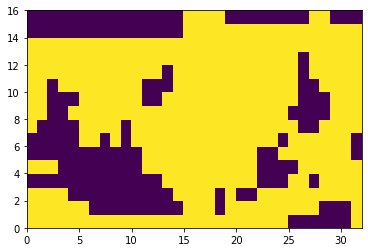

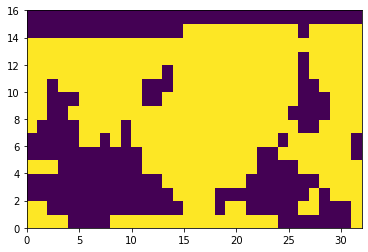

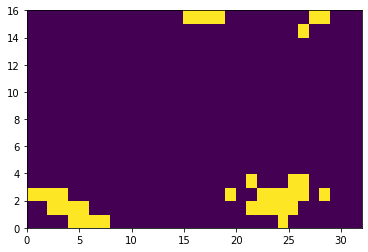

[ 0.00000000e+00     +0.j          2.04383858e+05     +0.j
 -2.70740471e+04 -41358.8273374j  -2.13625559e+05     +0.j
  2.93628157e+04 +79577.98015225j  2.89662535e+04  +6829.43821089j
  9.89782748e+04     +0.j         -2.53549028e+04-109187.62646524j
 -5.61240127e+04 -26962.72235551j  1.55359500e+03 +25090.40700385j
 -6.82234127e+04     +0.j          2.74339989e+04+106195.60450176j
  8.26180367e+04 +26011.09090759j  6.93744438e+03 -34084.49755315j
 -1.31625163e+03 +17011.41903626j -7.18359371e+04     +0.j
 -2.91768708e+04 -80134.10106453j -9.05663555e+04 -34338.6898736j
 -7.98445279e+03 +63439.80022618j  2.48994434e+04  -5076.39119794j
 -8.30711343e+02  +6104.5491018j   6.40939633e+04     +0.j
  1.88265158e+04 +24183.92379788j  8.35090334e+04 +45821.10025369j
  1.13213368e+04 -89388.53680464j -2.70778567e+04 +12733.58390815j
  2.15937963e+03  +3048.58199387j  1.67265909e+02  -1276.69895938j
 -1.32254617e+05     +0.j         -8.08751035e+03 +18588.22045866j
 -5.98026053e+04 -57708.3549

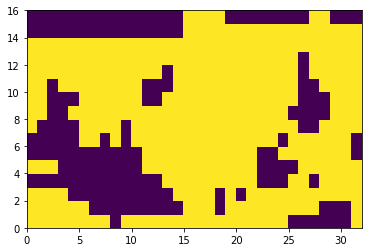

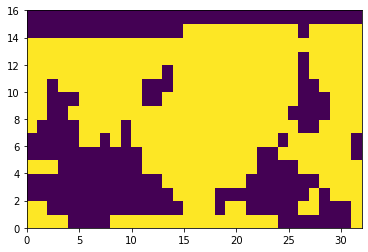

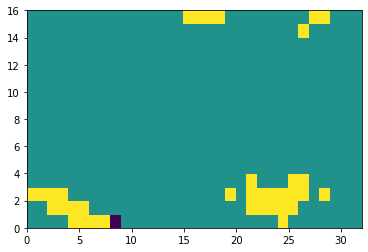

[-1.36244649e+05+0.00000000e+00j  3.37023248e+05+0.00000000e+00j
 -2.71297683e+04-8.56447279e+04j -3.49180236e+05+0.00000000e+00j
  3.55885488e+04+1.48717844e+05j  4.30765734e+04+1.17651308e+04j
  1.75553815e+05+0.00000000e+00j -3.32329664e+04-2.01867983e+05j
 -8.65932502e+04-3.87080261e+04j -1.22453340e+03+3.06626799e+04j
 -9.70759091e+04+0.00000000e+00j  3.59262824e+04+1.85236848e+05j
  1.27885890e+05+5.16309696e+04j  1.10665311e+04-5.45703249e+04j
 -4.48091251e+03+1.52169529e+04j -1.09052716e+05+0.00000000e+00j
 -3.37191282e+04-1.40066818e+05j -1.45505296e+05-7.44041698e+04j
 -1.91832096e+04+9.90445796e+04j  2.72618820e+04-1.00642806e+04j
 -3.46293421e+03+4.71458627e+03j  1.28066313e+05+0.00000000e+00j
  2.40231031e+04+4.23571807e+04j  1.39526641e+05+9.27740357e+04j
  3.40229107e+04-1.38506471e+05j -3.68775171e+04+1.98479477e+04j
  8.20156952e+03+1.61767728e+03j -2.80473300e+02-2.28170354e+03j
 -2.17629565e+05+0.00000000e+00j -1.08863149e+04+2.60678216e+04j
 -1.06047964e+05-1.081425

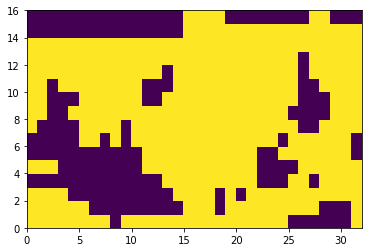

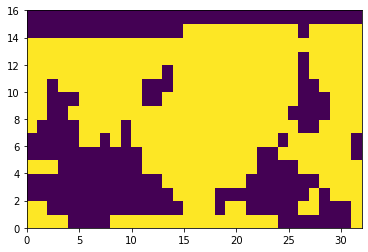

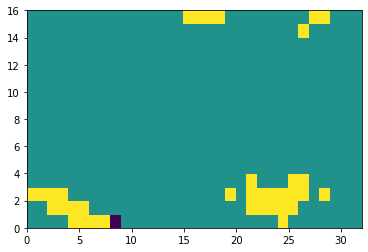

[-1.46687280e+05+0.00000000e+00j  3.72274014e+05+0.00000000e+00j
 -2.66795368e+04-9.64500911e+04j -3.80479538e+05+0.00000000e+00j
  3.41026783e+04+1.61425919e+05j  4.64367874e+04+1.43758873e+04j
  1.92765295e+05+0.00000000e+00j -2.96815258e+04-2.22113776e+05j
 -9.25650713e+04-4.47751314e+04j -2.06755111e+03+3.26351614e+04j
 -1.05126331e+05+0.00000000e+00j  3.25473243e+04+2.03444049e+05j
  1.36174736e+05+6.02369914e+04j  1.35721696e+04-5.54441801e+04j
 -3.31973300e+03+1.65154519e+04j -1.15764856e+05+0.00000000e+00j
 -3.23031501e+04-1.54011997e+05j -1.55185393e+05-8.57315114e+04j
 -2.47062748e+04+1.01242061e+05j  2.74414227e+04-9.78553698e+03j
 -3.62839820e+03+5.35197266e+03j  1.39243370e+05+0.00000000e+00j
  2.36047174e+04+4.95775324e+04j  1.49707220e+05+1.05692757e+05j
  4.21197174e+04-1.42367722e+05j -3.52888658e+04+1.87662230e+04j
  8.93722363e+03+4.33337250e+02j -1.60759778e+02-2.59464150e+03j
 -2.34258982e+05+0.00000000e+00j -1.23066368e+04+2.78026235e+04j
 -1.14615476e+05-1.207653

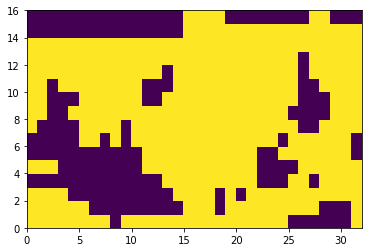

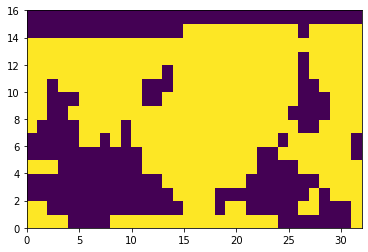

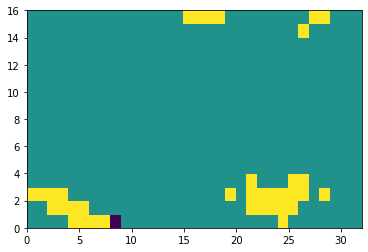

[-1.46687280e+05+0.00000000e+00j  3.81510845e+05+0.00000000e+00j
 -2.69045143e+04-9.88853214e+04j -3.88782337e+05+0.00000000e+00j
  3.41915031e+04+1.64219972e+05j  4.74865032e+04+1.50425295e+04j
  1.97204793e+05+0.00000000e+00j -2.95423870e+04-2.27240538e+05j
 -9.45370730e+04-4.62753494e+04j -2.27283071e+03+3.35220561e+04j
 -1.07363306e+05+0.00000000e+00j  3.25504337e+04+2.08320843e+05j
  1.39155492e+05+6.18419466e+04j  1.41120070e+04-5.62561147e+04j
 -3.12407415e+03+1.71272155e+04j -1.18150488e+05+0.00000000e+00j
 -3.28269518e+04-1.57398125e+05j -1.58507731e+05-8.76967775e+04j
 -2.56450192e+04+1.03022794e+05j  2.81535400e+04-9.79380364e+03j
 -3.59923592e+03+5.61739830e+03j  1.42125047e+05+0.00000000e+00j
  2.39014304e+04+5.11863808e+04j  1.52882780e+05+1.08058341e+05j
  4.32815267e+04-1.44977434e+05j -3.57481698e+04+1.87271022e+04j
  8.99235850e+03+3.45576265e+02j -1.33222973e+02-2.61864554e+03j
 -2.38889211e+05+0.00000000e+00j -1.25714621e+04+2.85922635e+04j
 -1.16882955e+05-1.230989

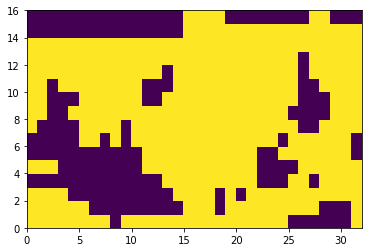

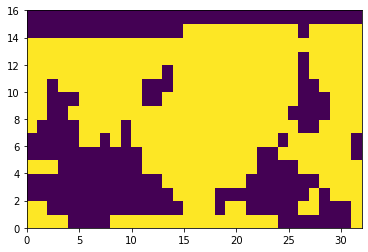

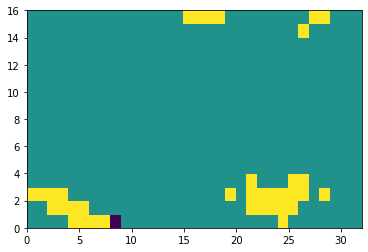

[-1.46687280e+05+0.00000000e+00j  3.85123728e+05+0.00000000e+00j
 -2.70433330e+04-9.96692216e+04j -3.92451632e+05+0.00000000e+00j
  3.44990969e+04+1.65417159e+05j  4.80189911e+04+1.53438277e+04j
  1.99607753e+05+0.00000000e+00j -2.98282233e+04-2.29641783e+05j
 -9.56888658e+04-4.68730023e+04j -2.35030333e+03+3.40097133e+04j
 -1.08519243e+05+0.00000000e+00j  3.28447504e+04+2.10863527e+05j
  1.41032666e+05+6.25931858e+04j  1.43378347e+04-5.70345252e+04j
 -3.14672487e+03+1.73665360e+04j -1.19592201e+05+0.00000000e+00j
 -3.32777150e+04-1.59240592e+05j -1.60618248e+05-8.87077376e+04j
 -2.60181671e+04+1.04431510e+05j  2.86399986e+04-9.86456293e+03j
 -3.57904091e+03+5.68708197e+03j  1.44089824e+05+0.00000000e+00j
  2.41303032e+04+5.19748048e+04j  1.54846572e+05+1.09296630e+05j
  4.37654829e+04-1.46865643e+05j -3.62593221e+04+1.88507268e+04j
  9.00848874e+03+4.14468970e+02j -1.11318220e+02-2.62452105e+03j
 -2.41894645e+05+0.00000000e+00j -1.26872170e+04+2.90481916e+04j
 -1.18257699e+05-1.244435

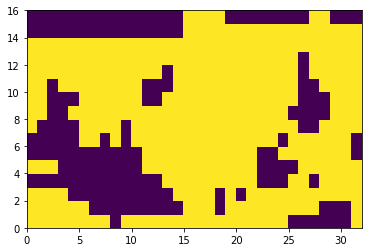

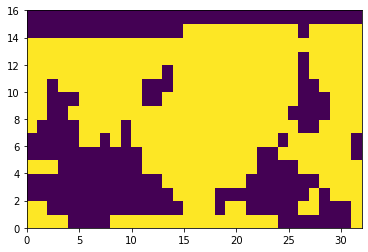

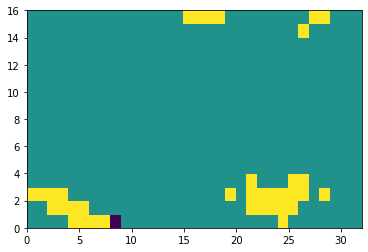

[-1.46687280e+05+0.00000000e+00j  3.87454888e+05+0.00000000e+00j
 -2.71298256e+04-1.00120013e+05j -3.94822060e+05+0.00000000e+00j
  3.46680615e+04+1.66424339e+05j  4.84318869e+04+1.55925552e+04j
  2.01231743e+05+0.00000000e+00j -3.00443093e+04-2.31270130e+05j
 -9.66054466e+04-4.73523588e+04j -2.42141535e+03+3.43627758e+04j
 -1.09172270e+05+0.00000000e+00j  3.30503081e+04+2.12690119e+05j
  1.42549228e+05+6.32459466e+04j  1.45809294e+04-5.77172069e+04j
 -3.20380021e+03+1.74782442e+04j -1.20792257e+05+0.00000000e+00j
 -3.36002711e+04-1.60556976e+05j -1.62320312e+05-8.95655016e+04j
 -2.63990732e+04+1.05593932e+05j  2.90159787e+04-9.84544749e+03j
 -3.53901225e+03+5.72773811e+03j  1.45706908e+05+0.00000000e+00j
  2.43190003e+04+5.24363494e+04j  1.56372508e+05+1.10283600e+05j
  4.42597558e+04-1.48386436e+05j -3.67000833e+04+1.88327760e+04j
  8.94860376e+03+4.80746470e+02j -9.45481569e+01-2.62310649e+03j
 -2.44205045e+05+0.00000000e+00j -1.28056404e+04+2.95079792e+04j
 -1.19281321e+05-1.254743

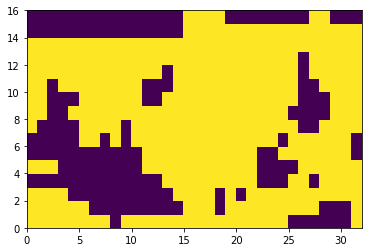

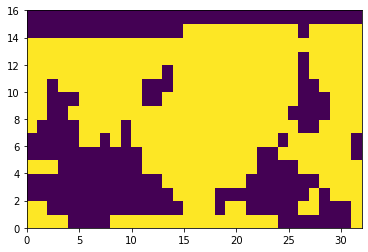

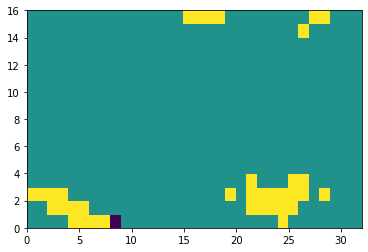

[-1.46687280e+05+0.00000000e+00j  3.88643609e+05+0.00000000e+00j
 -2.71855085e+04-1.00329972e+05j -3.95946860e+05+0.00000000e+00j
  3.47147936e+04+1.66994755e+05j  4.86334282e+04+1.57096122e+04j
  2.01977784e+05+0.00000000e+00j -3.01483155e+04-2.32023869e+05j
 -9.70414501e+04-4.75775582e+04j -2.44734955e+03+3.45235360e+04j
 -1.09442188e+05+0.00000000e+00j  3.31402596e+04+2.13552787e+05j
  1.43273811e+05+6.35414535e+04j  1.46924242e+04-5.80367904e+04j
 -3.22716991e+03+1.75340074e+04j -1.21373767e+05+0.00000000e+00j
 -3.37412572e+04-1.61170264e+05j -1.63127285e+05-8.99549479e+04j
 -2.65606204e+04+1.06140145e+05j  2.91893321e+04-9.83919603e+03j
 -3.51822703e+03+5.75574274e+03j  1.46477703e+05+0.00000000e+00j
  2.43967673e+04+5.26428412e+04j  1.57087656e+05+1.10743835e+05j
  4.44762315e+04-1.49106617e+05j -3.69077654e+04+1.88323455e+04j
  8.91317317e+03+5.10279604e+02j -8.89034528e+01-2.62246586e+03j
 -2.45285869e+05+0.00000000e+00j -1.28514535e+04+2.97404687e+04j
 -1.19746576e+05-1.259554

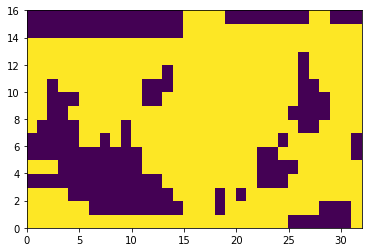

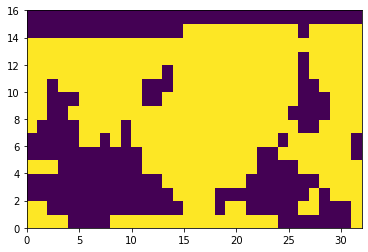

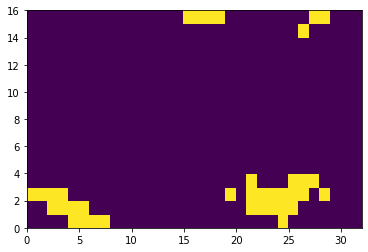

[-1.46687280e+05+0.00000000e+00j  3.96483174e+05+0.00000000e+00j
 -2.98731088e+04-1.03363314e+05j -4.00866482e+05+0.00000000e+00j
  3.85248165e+04+1.72545908e+05j  5.01003538e+04+1.32699715e+04j
  2.01442478e+05+0.00000000e+00j -3.37203670e+04-2.37804464e+05j
 -9.98342764e+04-4.30208925e+04j -4.67962324e+02+3.46275875e+04j
 -1.04891633e+05+0.00000000e+00j  3.51890859e+04+2.17571572e+05j
  1.47020578e+05+5.71330887e+04j  1.05604707e+04-5.73745971e+04j
 -2.16288578e+03+1.89951932e+04j -1.29023668e+05+0.00000000e+00j
 -3.35829689e+04-1.61108814e+05j -1.66555834e+05-8.39749547e+04j
 -2.01452538e+04+1.05304697e+05j  2.73130676e+04-1.21104071e+04j
 -3.61727876e+03+6.93347881e+03j  1.51904719e+05+0.00000000e+00j
  2.17650883e+04+4.88991452e+04j  1.59042867e+05+1.07838239e+05j
  3.70879346e+04-1.48277461e+05j -3.30552169e+04+2.28155987e+04j
  9.20671807e+03-1.93445343e+03j -6.71289482e+02-2.34969028e+03j
 -2.47367740e+05+0.00000000e+00j -9.21110289e+03+3.58097479e+04j
 -1.19572548e+05-1.272078

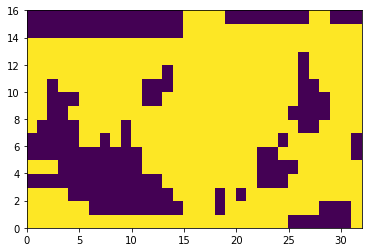

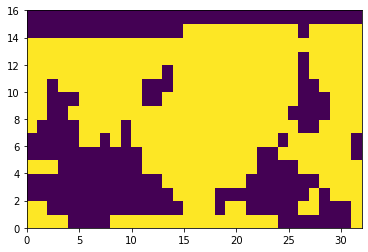

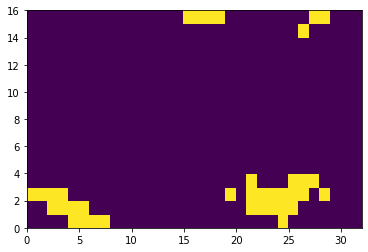

[-1.52300824e+05+0.00000000e+00j  4.01860514e+05+0.00000000e+00j
 -3.16219920e+04-1.06440240e+05j -4.04430770e+05+0.00000000e+00j
  4.18585238e+04+1.77568241e+05j  5.08513471e+04+1.11172887e+04j
  2.01003280e+05+0.00000000e+00j -3.68047254e+04-2.43265633e+05j
 -1.01584518e+05-3.87010970e+04j  1.03588612e+03+3.41207319e+04j
 -1.00692024e+05+0.00000000e+00j  3.71534527e+04+2.21209925e+05j
  1.49591734e+05+5.16993127e+04j  6.97846070e+03-5.66561239e+04j
 -1.27695236e+03+1.95055926e+04j -1.35241372e+05+0.00000000e+00j
 -3.36247510e+04-1.61691847e+05j -1.69001376e+05-7.95095678e+04j
 -1.48893086e+04+1.04501455e+05j  2.52060846e+04-1.40379440e+04j
 -3.70255522e+03+7.67973895e+03j  1.57347901e+05+0.00000000e+00j
  1.98930863e+04+4.65140282e+04j  1.60445158e+05+1.05766863e+05j
  3.12700055e+04-1.47556022e+05j -2.97120544e+04+2.60512453e+04j
  9.52181254e+03-4.08831927e+03j -1.20914458e+03-2.10693088e+03j
 -2.49916960e+05+0.00000000e+00j -6.37432134e+03+3.96168782e+04j
 -1.19502658e+05-1.282660

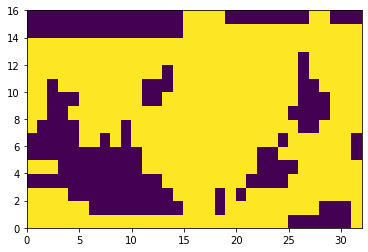

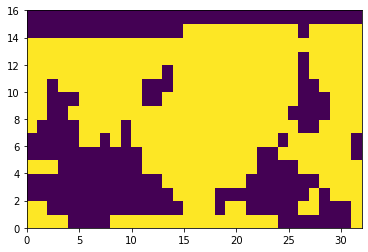

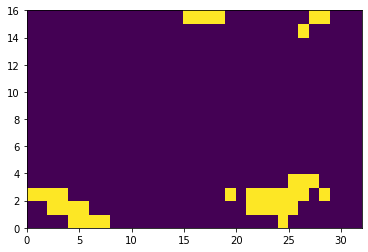

[-1.52300824e+05+0.00000000e+00j  3.96607730e+05+0.00000000e+00j
 -3.38197168e+04-1.04278660e+05j -4.01504116e+05+0.00000000e+00j
  4.62958983e+04+1.73365270e+05j  4.99191392e+04+8.02273056e+03j
  2.02307487e+05+0.00000000e+00j -4.13871696e+04-2.39123565e+05j
 -9.97866287e+04-3.22616141e+04j  3.26023383e+03+3.42896810e+04j
 -1.05089107e+05+0.00000000e+00j  3.99328823e+04+2.18680154e+05j
  1.47294906e+05+4.40024838e+04j  1.77387469e+03-5.78242040e+04j
 -2.31551274e+03+2.02413028e+04j -1.29123936e+05+0.00000000e+00j
 -3.33479613e+04-1.62523602e+05j -1.67059470e+05-7.29337658e+04j
 -7.29554298e+03+1.06273027e+05j  2.73493769e+04-1.68958476e+04j
 -3.89265654e+03+6.59071392e+03j  1.53439576e+05+0.00000000e+00j
  1.69755643e+04+5.02646244e+04j  1.59700158e+05+1.02504288e+05j
  2.30044373e+04-1.49668263e+05j -3.39080528e+04+3.07844109e+04j
  1.01297905e+04-1.62663889e+03j -6.04288353e+02-1.80519505e+03j
 -2.49614436e+05+0.00000000e+00j -2.18229583e+03+3.43318848e+04j
 -1.20314700e+05-1.297693

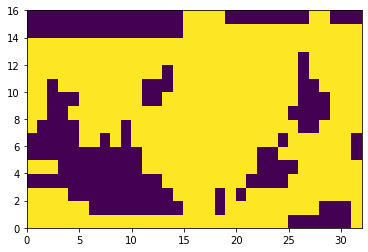

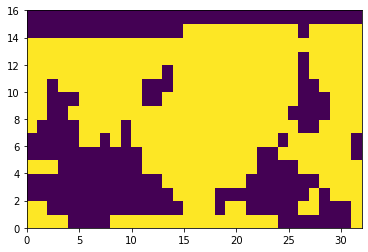

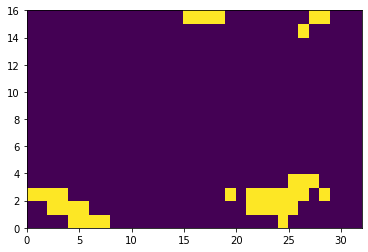

[-1.48333068e+05+0.00000000e+00j  3.92747920e+05+0.00000000e+00j
 -3.56120302e+04-1.01975231e+05j -3.99472717e+05+0.00000000e+00j
  4.93362821e+04+1.70107796e+05j  4.93472098e+04+6.31299956e+03j
  2.03238838e+05+0.00000000e+00j -4.41602061e+04-2.35754311e+05j
 -9.87691957e+04-2.83587029e+04j  4.87195625e+03+3.47108736e+04j
 -1.08259503e+05+0.00000000e+00j  4.16897891e+04+2.16854314e+05j
  1.45982371e+05+3.91782544e+04j -1.40816979e+03-5.85423354e+04j
 -2.86353643e+03+2.09673026e+04j -1.25144854e+05+0.00000000e+00j
 -3.33065200e+04-1.63187100e+05j -1.65864006e+05-6.88745665e+04j
 -2.72571369e+03+1.07294368e+05j  2.89198255e+04-1.84666637e+04j
 -3.85579503e+03+5.85657108e+03j  1.50292876e+05+0.00000000e+00j
  1.53637815e+04+5.28710402e+04j  1.59132170e+05+1.00219219e+05j
  1.77173068e+04-1.50996741e+05j -3.67075165e+04+3.38265518e+04j
  1.05540448e+04+1.42526494e+02j -1.51674959e+02-1.82945608e+03j
 -2.49297875e+05+0.00000000e+00j -3.46427618e+01+3.09466162e+04j
 -1.20754670e+05-1.305533

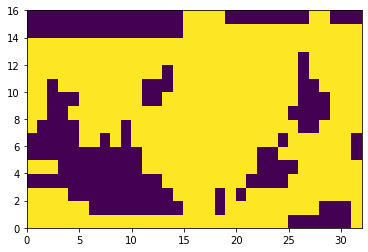

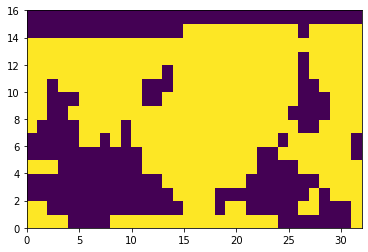

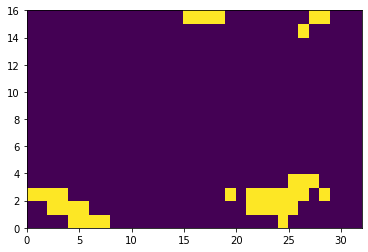

[-1.48333068e+05+0.00000000e+00j  3.93311444e+05+0.00000000e+00j
 -3.57470612e+04-1.02028823e+05j -4.00104921e+05+0.00000000e+00j
  4.95978543e+04+1.70730462e+05j  4.95386599e+04+6.38467387e+03j
  2.03576859e+05+0.00000000e+00j -4.41753582e+04-2.36346596e+05j
 -9.92354491e+04-2.84064798e+04j  4.91252494e+03+3.48219374e+04j
 -1.07926017e+05+0.00000000e+00j  4.16950046e+04+2.17413747e+05j
  1.46650619e+05+3.94266788e+04j -1.22770094e+03-5.87705069e+04j
 -2.84692207e+03+2.09416350e+04j -1.25963925e+05+0.00000000e+00j
 -3.33271837e+04-1.63404606e+05j -1.66522690e+05-6.92887312e+04j
 -3.06298435e+03+1.07629272e+05j  2.89210404e+04-1.82853884e+04j
 -3.76652368e+03+5.88536550e+03j  1.51076682e+05+0.00000000e+00j
  1.54607831e+04+5.25680741e+04j  1.59578932e+05+1.00546140e+05j
  1.81120368e+04-1.51447674e+05j -3.67039896e+04+3.36354515e+04j
  1.04440592e+04+7.92881476e+01j -1.84796932e+02-1.85826450e+03j
 -2.49887277e+05+0.00000000e+00j -2.42823987e+02+3.15731120e+04j
 -1.20886134e+05-1.307857

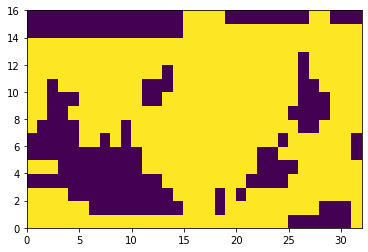

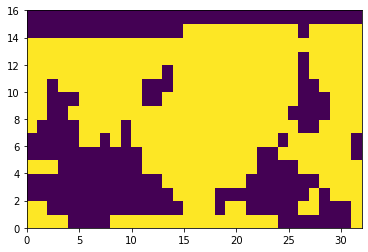

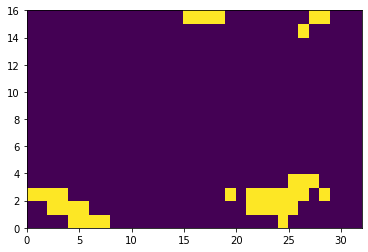

[-1.48333068e+05+0.00000000e+00j  3.94247546e+05+0.00000000e+00j
 -3.57290488e+04-1.02315207e+05j -4.00802595e+05+0.00000000e+00j
  4.95189784e+04+1.71356261e+05j  4.97633415e+04+6.55175195e+03j
  2.03743672e+05+0.00000000e+00j -4.40929267e+04-2.37018912e+05j
 -9.96823971e+04-2.87055797e+04j  4.81785267e+03+3.49397688e+04j
 -1.07587657e+05+0.00000000e+00j  4.16487511e+04+2.17988952e+05j
  1.47309092e+05+3.98023967e+04j -9.50116513e+02-5.90026342e+04j
 -2.82869346e+03+2.09192390e+04j -1.26789008e+05+0.00000000e+00j
 -3.33712598e+04-1.63566825e+05j -1.67193263e+05-6.96721151e+04j
 -3.45160336e+03+1.08031838e+05j  2.89813459e+04-1.80852205e+04j
 -3.69296186e+03+5.96924686e+03j  1.51811470e+05+0.00000000e+00j
  1.55432304e+04+5.23041956e+04j  1.60068626e+05+1.00885765e+05j
  1.85623070e+04-1.51985190e+05j -3.67539837e+04+3.33060266e+04j
  1.02619160e+04-1.20219878e+01j -2.28703089e+02-1.81807990e+03j
 -2.50472925e+05+0.00000000e+00j -3.46520984e+02+3.21672963e+04j
 -1.21028506e+05-1.309765

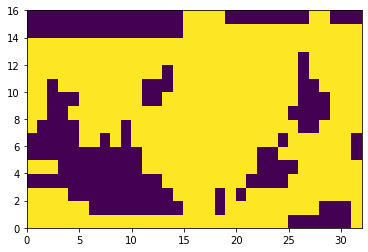

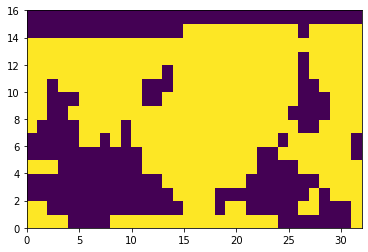

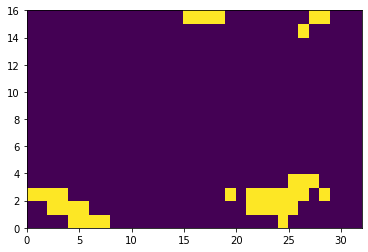

[-1.48333068e+05+0.00000000e+00j  3.96349934e+05+0.00000000e+00j
 -3.53764639e+04-1.03065019e+05j -4.02159764e+05+0.00000000e+00j
  4.87322189e+04+1.72783294e+05j  5.01329684e+04+7.20123758e+03j
  2.03673737e+05+0.00000000e+00j -4.32745480e+04-2.38511340e+05j
 -1.00410165e+05-3.00154669e+04j  4.39163169e+03+3.49776824e+04j
 -1.06423211e+05+0.00000000e+00j  4.11262372e+04+2.19088529e+05j
  1.48347645e+05+4.13847441e+04j  7.95460506e+01-5.89422605e+04j
 -2.58307293e+03+2.08458972e+04j -1.28822136e+05+0.00000000e+00j
 -3.34007253e+04-1.63611505e+05j -1.68187876e+05-7.11042030e+04j
 -4.92940791e+03+1.08033748e+05j  2.85927651e+04-1.75500037e+04j
 -3.62075963e+03+6.28511860e+03j  1.53338177e+05+0.00000000e+00j
  1.60277856e+04+5.14086235e+04j  1.60708888e+05+1.01814187e+05j
  2.02232650e+04-1.52082896e+05j -3.59695546e+04+3.24252150e+04j
  1.00933433e+04-5.68713655e+02j -3.68707659e+02-1.84852225e+03j
 -2.51247922e+05+0.00000000e+00j -1.06662029e+03+3.36942904e+04j
 -1.21068620e+05-1.310192

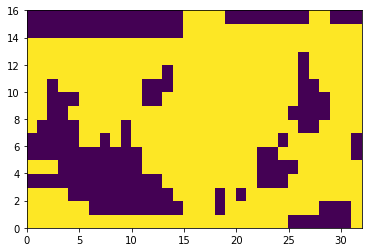

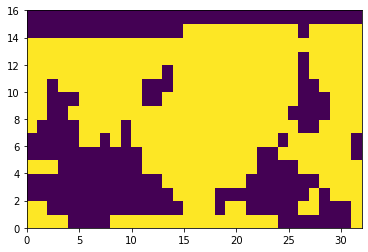

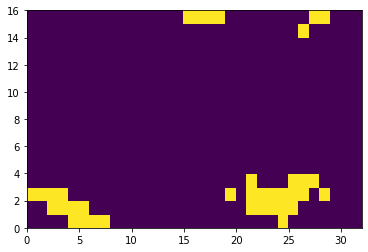

[-1.48333068e+05+0.00000000e+00j  4.03644337e+05+0.00000000e+00j
 -3.37927291e+04-1.06058017e+05j -4.06504347e+05+0.00000000e+00j
  4.53543845e+04+1.77984647e+05j  5.15148028e+04+9.79268408e+03j
  2.02671194e+05+0.00000000e+00j -3.95083758e+04-2.43881784e+05j
 -1.02962593e+05-3.56458393e+04j  2.47570151e+03+3.50197138e+04j
 -1.01753021e+05+0.00000000e+00j  3.87544678e+04+2.22676046e+05j
  1.51731529e+05+4.81325586e+04j  4.63161736e+03-5.82302500e+04j
 -1.57469537e+03+2.03689240e+04j -1.36198293e+05+0.00000000e+00j
 -3.36843879e+04-1.63217495e+05j -1.71247179e+05-7.69629155e+04j
 -1.15705136e+04+1.07144126e+05j  2.67943948e+04-1.50320099e+04j
 -3.38817518e+03+7.48913618e+03j  1.58492341e+05+0.00000000e+00j
  1.84085540e+04+4.76351060e+04j  1.62384871e+05+1.05166491e+05j
  2.75976510e+04-1.51141806e+05j -3.22313481e+04+2.81527231e+04j
  9.32702794e+03-2.97099492e+03j -9.60024296e+02-1.97659152e+03j
 -2.52972245e+05+0.00000000e+00j -4.50696310e+03+3.95611572e+04j
 -1.20699518e+05-1.302696

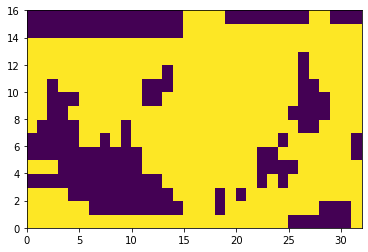

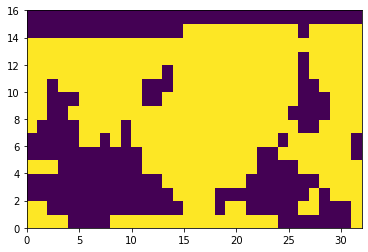

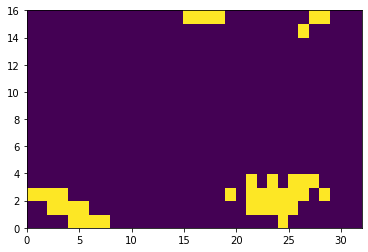

[-1.52300824e+05+0.00000000e+00j  4.17952152e+05+0.00000000e+00j
 -3.21490951e+04-1.13440039e+05j -4.14998759e+05+0.00000000e+00j
  4.16497306e+04+1.90159713e+05j  5.64515511e+04+1.27150419e+04j
  2.00697902e+05+0.00000000e+00j -3.54818417e+04-2.56540411e+05j
 -1.12435308e+05-4.23143119e+04j -3.10706064e+02+3.78840905e+04j
 -9.21438083e+04+0.00000000e+00j  3.61512471e+04+2.30665534e+05j
  1.64116416e+05+5.59324851e+04j  1.09510236e+04-6.37497091e+04j
 -2.58954204e+03+1.90093811e+04j -1.50590888e+05+0.00000000e+00j
 -3.39585954e+04-1.62172216e+05j -1.82506527e+05-8.35375085e+04j
 -2.07016636e+04+1.15800986e+05j  3.02366437e+04-9.99746044e+03j
 -2.08927954e+03+7.55864581e+03j  1.68966822e+05+0.00000000e+00j
  2.07551121e+04+3.87845758e+04j  1.68428005e+05+1.09078669e+05j
  3.78097238e+04-1.60912238e+05j -3.71089356e+04+1.94174517e+04j
  5.37604670e+03-1.89617814e+03j -8.87991351e+02-9.14814176e+02j
 -2.55977675e+05+0.00000000e+00j -7.83240760e+03+5.27135900e+04j
 -1.19046555e+05-1.294273

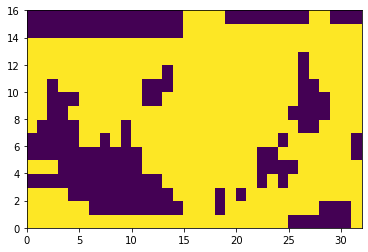

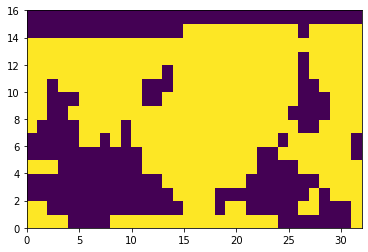

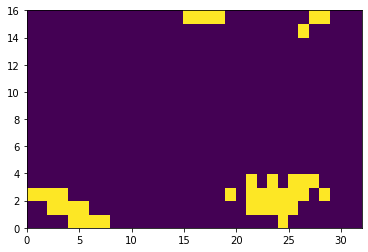

[-1.61342410e+05+0.00000000e+00j  4.29941939e+05+0.00000000e+00j
 -3.05264367e+04-1.20477048e+05j -4.22392959e+05+0.00000000e+00j
  3.87348010e+04+2.01128134e+05j  6.08969333e+04+1.49264558e+04j
  1.99683081e+05+0.00000000e+00j -3.29164468e+04-2.68313174e+05j
 -1.21016276e+05-4.62923265e+04j -2.38903202e+03+4.05107840e+04j
 -8.38081107e+04+0.00000000e+00j  3.46481275e+04+2.37778604e+05j
  1.75389657e+05+6.10574855e+04j  1.52238610e+04-6.96681397e+04j
 -3.83048603e+03+1.73707709e+04j -1.62323945e+05+0.00000000e+00j
 -3.41004020e+04-1.61761977e+05j -1.92938164e+05-8.83251318e+04j
 -2.72495740e+04+1.24974216e+05j  3.37306673e+04-6.09022025e+03j
 -7.39882110e+02+6.78233034e+03j  1.78399273e+05+0.00000000e+00j
  2.22137167e+04+3.13462846e+04j  1.74472185e+05+1.11785474e+05j
  4.50210164e+04-1.71442211e+05j -4.32313945e+04+1.27754133e+04j
  2.12567982e+03-3.11442518e+01j -5.48445637e+02-1.60730372e+01j
 -2.58613088e+05+0.00000000e+00j -9.90709456e+03+6.38393413e+04j
 -1.17911962e+05-1.289340

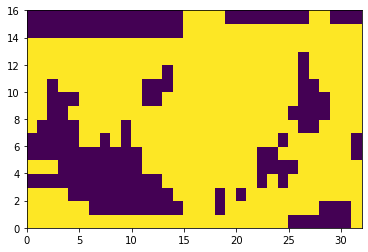

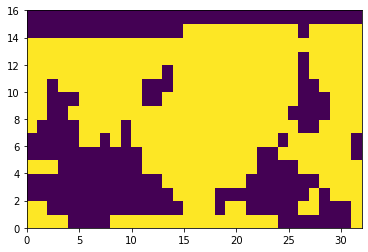

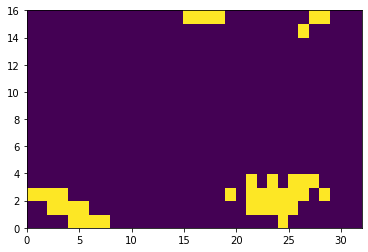

[-1.61342410e+05+0.00000000e+00j  4.32112293e+05+0.00000000e+00j
 -3.04019638e+04-1.21594549e+05j -4.23679593e+05+0.00000000e+00j
  3.82699702e+04+2.01976834e+05j  6.15204831e+04+1.52367486e+04j
  1.99708024e+05+0.00000000e+00j -3.26326396e+04-2.69701228e+05j
 -1.21828280e+05-4.68286904e+04j -2.61964005e+03+4.08795589e+04j
 -8.34442687e+04+0.00000000e+00j  3.44601306e+04+2.38712248e+05j
  1.76355813e+05+6.14961296e+04j  1.54839418e+04-7.00395257e+04j
 -3.82220019e+03+1.74180326e+04j -1.63351835e+05+0.00000000e+00j
 -3.41485918e+04-1.62053965e+05j -1.93871617e+05-8.87079204e+04j
 -2.76230005e+04+1.25569584e+05j  3.39907241e+04-5.94824969e+03j
 -7.08789631e+02+6.82327686e+03j  1.79136124e+05+0.00000000e+00j
  2.22991548e+04+3.11910983e+04j  1.75183209e+05+1.12176919e+05j
  4.54176806e+04-1.72187439e+05j -4.34710415e+04+1.24771751e+04j
  2.04963081e+03-1.97032584e+01j -5.25169010e+02+3.99565458e+01j
 -2.59341345e+05+0.00000000e+00j -1.00200593e+04+6.45810496e+04j
 -1.18168665e+05-1.291782

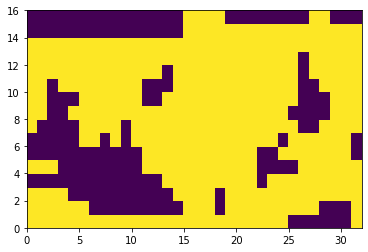

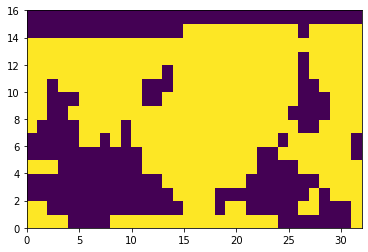

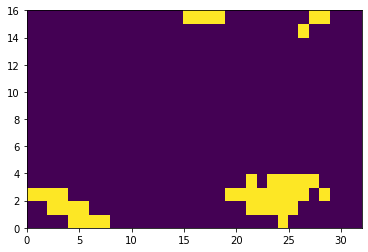

[-1.61342410e+05+0.00000000e+00j  4.53594424e+05+0.00000000e+00j
 -2.97699542e+04-1.30242243e+05j -4.38828678e+05+0.00000000e+00j
  3.46576766e+04+2.17501567e+05j  6.76234221e+04+1.71584568e+04j
  2.01536156e+05+0.00000000e+00j -2.65974397e+04-2.87074190e+05j
 -1.33424241e+05-5.20910586e+04j -3.16889301e+03+4.51494806e+04j
 -7.50815879e+04+0.00000000e+00j  2.82016555e+04+2.52264762e+05j
  1.91353804e+05+6.80019422e+04j  1.77655771e+04-7.68281914e+04j
 -5.63272398e+03+1.87312238e+04j -1.81222581e+05+0.00000000e+00j
 -2.98029063e+04-1.65503357e+05j -2.07261982e+05-9.62480569e+04j
 -3.11586532e+04+1.35646005e+05j  4.04488689e+04-5.45627216e+03j
 -7.01710782e+02+5.86881897e+03j  1.94595804e+05+0.00000000e+00j
  1.98801322e+04+2.48486736e+04j  1.82063013e+05+1.20670407e+05j
  4.99342335e+04-1.82544009e+05j -5.21575561e+04+1.19655712e+04j
  2.10458812e+03+4.49168185e+03j  7.30518651e+02-1.39317837e+01j
 -2.69783858e+05+0.00000000e+00j -1.06949539e+04+7.85362172e+04j
 -1.15930351e+05-1.365677

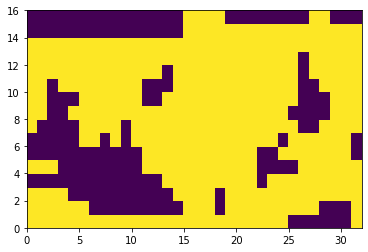

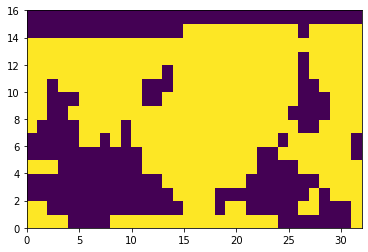

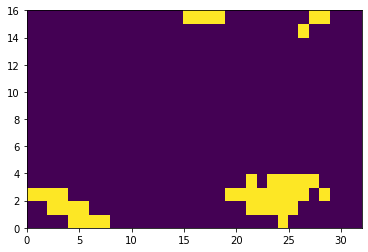

[-1.79032680e+05+0.00000000e+00j  4.70777236e+05+0.00000000e+00j
 -2.71150424e+04-1.39080755e+05j -4.51308782e+05+0.00000000e+00j
  2.99944774e+04+2.31315972e+05j  7.16984940e+04+1.87079914e+04j
  2.05194684e+05+0.00000000e+00j -2.09758306e+04-3.02791934e+05j
 -1.41098478e+05-5.54850836e+04j -3.76833180e+03+4.73129241e+04j
 -6.89848555e+04+0.00000000e+00j  2.24858919e+04+2.63589128e+05j
  2.01098403e+05+7.39571377e+04j  1.87713812e+04-8.15658165e+04j
 -7.07473918e+03+1.83302643e+04j -1.93391490e+05+0.00000000e+00j
 -2.54593650e+04-1.69893805e+05j -2.16032878e+05-1.04481316e+05j
 -3.36691310e+04+1.41941990e+05j  4.35694636e+04-6.13627022e+03j
 -1.21162958e+03+4.22509155e+03j  2.08884373e+05+0.00000000e+00j
  1.74882476e+04+2.14812715e+04j  1.87151575e+05+1.29627180e+05j
  5.40315730e+04-1.88550145e+05j -5.72538718e+04+1.25341859e+04j
  3.17080453e+03+7.52266244e+03j  1.61199873e+03-1.34164339e+02j
 -2.79573979e+05+0.00000000e+00j -1.07599420e+04+8.73973285e+04j
 -1.15057298e+05-1.447317

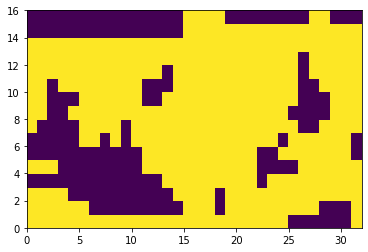

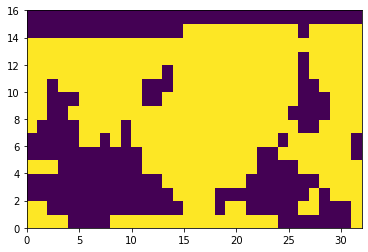

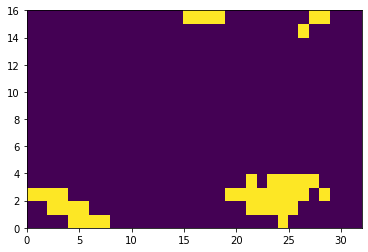

[-1.79032680e+05+0.00000000e+00j  4.74660965e+05+0.00000000e+00j
 -2.68132018e+04-1.40769046e+05j -4.53817262e+05+0.00000000e+00j
  2.89915603e+04+2.32928823e+05j  7.25371410e+04+1.90889623e+04j
  2.05534628e+05+0.00000000e+00j -2.00480899e+04-3.05295004e+05j
 -1.42269670e+05-5.63162880e+04j -3.92556382e+03+4.78266595e+04j
 -6.82808480e+04+0.00000000e+00j  2.16207547e+04+2.65455850e+05j
  2.02596665e+05+7.48621730e+04j  1.89729035e+04-8.20611121e+04j
 -7.09425761e+03+1.85608023e+04j -1.95425812e+05+0.00000000e+00j
 -2.49633436e+04-1.70537985e+05j -2.17466238e+05-1.05476918e+05j
 -3.40631181e+04+1.42715277e+05j  4.40305214e+04-6.14753549e+03j
 -1.20240052e+03+4.25336296e+03j  2.10510440e+05+0.00000000e+00j
  1.72221701e+04+2.11985066e+04j  1.88142931e+05+1.30745801e+05j
  5.45376707e+04-1.89438259e+05j -5.77084934e+04+1.24711540e+04j
  3.25127640e+03+7.67234397e+03j  1.72123291e+03-1.07457230e+02j
 -2.81046767e+05+0.00000000e+00j -1.07864355e+04+8.87788589e+04j
 -1.15235286e+05-1.456421

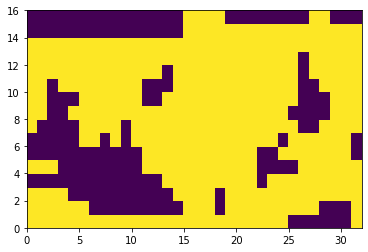

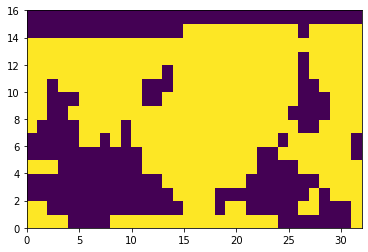

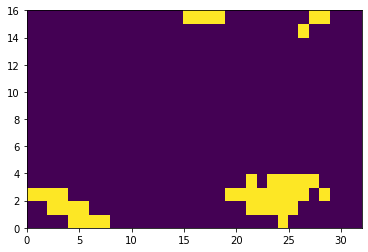

[-1.79032680e+05+0.00000000e+00j  4.75936695e+05+0.00000000e+00j
 -2.67750159e+04-1.41227769e+05j -4.54800786e+05+0.00000000e+00j
  2.87553548e+04+2.33537378e+05j  7.28259449e+04+1.91940375e+04j
  2.05853615e+05+0.00000000e+00j -1.98465639e+04-3.06139873e+05j
 -1.42723797e+05-5.65829485e+04j -3.97413226e+03+4.80113562e+04j
 -6.82138087e+04+0.00000000e+00j  2.14338833e+04+2.66147003e+05j
  2.03207435e+05+7.51544967e+04j  1.90756917e+04-8.22950515e+04j
 -7.12776658e+03+1.86296053e+04j -1.95953188e+05+0.00000000e+00j
 -2.48834448e+04-1.70824089e+05j -2.18066985e+05-1.05781781e+05j
 -3.42206368e+04+1.43093318e+05j  4.42275372e+04-6.10795919e+03j
 -1.18459243e+03+4.26471681e+03j  2.10906059e+05+0.00000000e+00j
  1.72095167e+04+2.11360928e+04j  1.88553684e+05+1.31086767e+05j
  5.47339728e+04-1.89880425e+05j -5.79349938e+04+1.24064168e+04j
  3.22945263e+03+7.75390252e+03j  1.75941924e+03-9.43640574e+01j
 -2.81374417e+05+0.00000000e+00j -1.08587649e+04+8.91729450e+04j
 -1.15330266e+05-1.459249

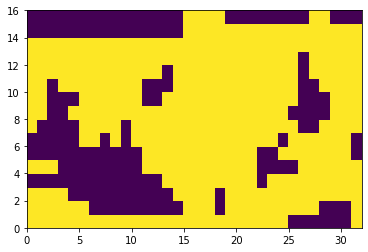

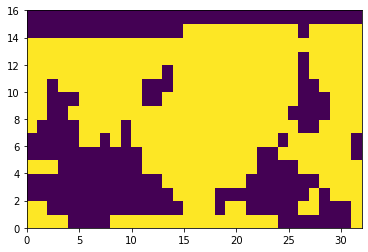

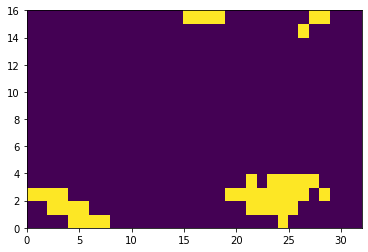

[-1.79032680e+05+0.00000000e+00j  4.76551979e+05+0.00000000e+00j
 -2.67603552e+04-1.41426677e+05j -4.55361646e+05+0.00000000e+00j
  2.86568861e+04+2.33929588e+05j  7.30158553e+04+1.92498169e+04j
  2.06062673e+05+0.00000000e+00j -1.97366266e+04-3.06653764e+05j
 -1.43065770e+05-5.67372377e+04j -4.00053360e+03+4.81244783e+04j
 -6.80931084e+04+0.00000000e+00j  2.13190709e+04+2.66566712e+05j
  2.03675394e+05+7.53671048e+04j  1.91694252e+04-8.25019978e+04j
 -7.17484012e+03+1.86549305e+04j -1.96369311e+05+0.00000000e+00j
 -2.48257648e+04-1.70957101e+05j -2.18526180e+05-1.06010238e+05j
 -3.43479208e+04+1.43408877e+05j  4.43738024e+04-6.05571569e+03j
 -1.16233574e+03+4.26259468e+03j  2.11277568e+05+0.00000000e+00j
  1.72067042e+04+2.09715447e+04j  1.88836606e+05+1.31335983e+05j
  5.48953022e+04-1.90240858e+05j -5.81347986e+04+1.23368923e+04j
  3.18870539e+03+7.83863054e+03j  1.78415342e+03-8.62653318e+01j
 -2.81659173e+05+0.00000000e+00j -1.09176760e+04+8.95551379e+04j
 -1.15369910e+05-1.461529

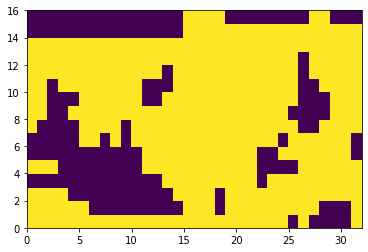

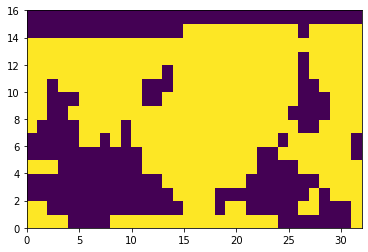

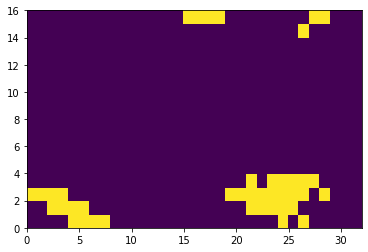

[-1.79032680e+05+0.00000000e+00j  4.79950966e+05+0.00000000e+00j
 -2.70290290e+04-1.41711815e+05j -4.59353504e+05+0.00000000e+00j
  2.88998253e+04+2.34700309e+05j  7.32742205e+04+1.92801374e+04j
  2.10111337e+05+0.00000000e+00j -1.99871849e+04-3.07898251e+05j
 -1.43523772e+05-5.69157430e+04j -3.99674970e+03+4.83371631e+04j
 -7.23908921e+04+0.00000000e+00j  2.17260551e+04+2.68298528e+05j
  2.04346041e+05+7.54033436e+04j  1.92953178e+04-8.26736012e+04j
 -7.18350117e+03+1.88206671e+04j -1.92335768e+05+0.00000000e+00j
 -2.55349483e+04-1.72855532e+05j -2.19256598e+05-1.05867621e+05j
 -3.44567525e+04+1.43707647e+05j  4.46383524e+04-5.95762192e+03j
 -1.12007365e+03+4.33297973e+03j  2.06879124e+05+0.00000000e+00j
  1.81157659e+04+2.31268950e+04j  1.89495537e+05+1.31111055e+05j
  5.49380037e+04-1.90600985e+05j -5.83477705e+04+1.22320524e+04j
  3.09416480e+03+7.93566187e+03j  1.80889292e+03-7.23323271e+01j
 -2.77410253e+05+0.00000000e+00j -1.20909638e+04+8.72438563e+04j
 -1.15941850e+05-1.457353

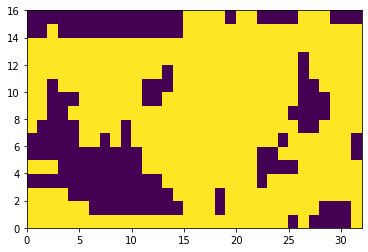

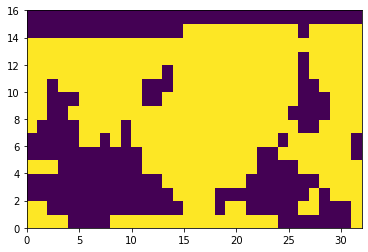

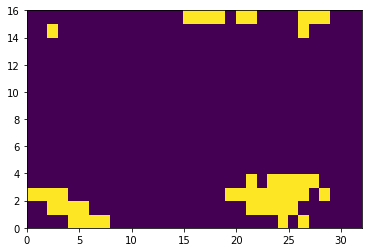

[-1.81151877e+05+0.00000000e+00j  4.70187263e+05+0.00000000e+00j
 -2.81064243e+04-1.42129929e+05j -4.82856844e+05+0.00000000e+00j
  2.95267590e+04+2.33601890e+05j  7.38072733e+04+1.95993525e+04j
  1.94210320e+05+0.00000000e+00j -1.99711731e+04-3.11080978e+05j
 -1.44436299e+05-5.69349853e+04j -3.93898896e+03+4.90757870e+04j
 -9.93161994e+04+0.00000000e+00j  2.25111207e+04+2.66805367e+05j
  2.05252039e+05+7.66335021e+04j  1.95226706e+04-8.25036093e+04j
 -6.98838187e+03+1.96620085e+04j -2.09117670e+05+0.00000000e+00j
 -2.57294149e+04-1.79786463e+05j -2.20409463e+05-1.03236663e+05j
 -3.49005740e+04+1.44184620e+05j  4.54548511e+04-5.55271551e+03j
 -9.76500537e+02+4.71598764e+03j  1.80814124e+05+0.00000000e+00j
  2.10346565e+04+1.93926136e+04j  1.89893593e+05+1.33386786e+05j
  5.43725662e+04-1.90393734e+05j -5.85911956e+04+1.20260926e+04j
  2.76217446e+03+8.14471303e+03j  1.82770671e+03-5.29960731e+01j
 -2.91373695e+05+0.00000000e+00j -1.11016801e+04+7.67993405e+04j
 -1.16404320e+05-1.410648

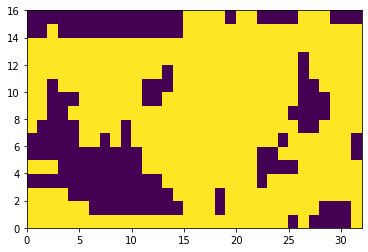

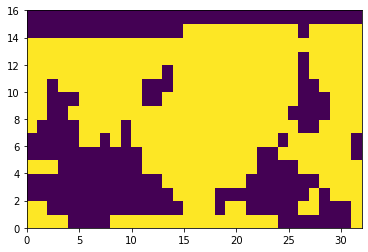

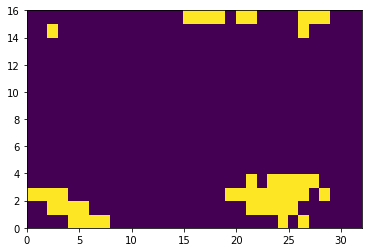

[-1.87393398e+05+0.00000000e+00j  4.63291760e+05+0.00000000e+00j
 -2.77528134e+04-1.42984609e+05j -4.92179388e+05+0.00000000e+00j
  2.96829183e+04+2.33297713e+05j  7.38517043e+04+1.96121837e+04j
  1.86274319e+05+0.00000000e+00j -1.95153896e+04-3.13246591e+05j
 -1.44500013e+05-5.64300825e+04j -4.03599917e+03+4.88032321e+04j
 -1.08275871e+05+0.00000000e+00j  2.32448715e+04+2.64874511e+05j
  2.05743721e+05+7.74151485e+04j  1.93655568e+04-8.26571892e+04j
 -7.13133873e+03+1.94003079e+04j -2.17043714e+05+0.00000000e+00j
 -2.47754274e+04-1.83375047e+05j -2.20298252e+05-1.02427664e+05j
 -3.49722106e+04+1.44326324e+05j  4.52164628e+04-5.57702495e+03j
 -1.07629246e+03+4.78727585e+03j  1.73169943e+05+0.00000000e+00j
  2.26665168e+04+1.53937255e+04j  1.90762109e+05+1.34979570e+05j
  5.43758916e+04-1.90478496e+05j -5.85388786e+04+1.19061166e+04j
  2.75832836e+03+8.12454289e+03j  1.75646721e+03+1.24047322e+02j
 -2.99052807e+05+0.00000000e+00j -9.30421384e+03+7.15166442e+04j
 -1.15577254e+05-1.395699

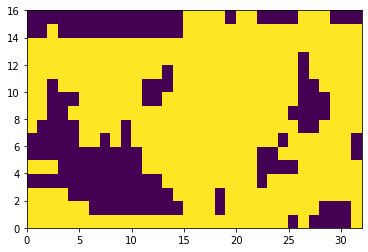

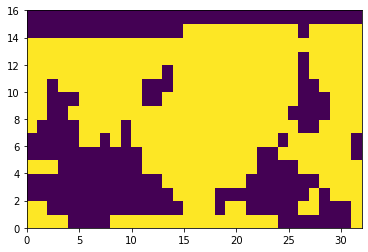

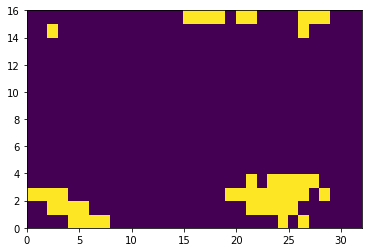

[-1.87393398e+05+0.00000000e+00j  4.62394430e+05+0.00000000e+00j
 -2.77910464e+04-1.43128626e+05j -4.93994997e+05+0.00000000e+00j
  2.98043319e+04+2.33367281e+05j  7.39842654e+04+1.96903531e+04j
  1.85311606e+05+0.00000000e+00j -1.93660531e+04-3.13652040e+05j
 -1.44753677e+05-5.65206249e+04j -4.04299564e+03+4.88977784e+04j
 -1.09220260e+05+0.00000000e+00j  2.33056322e+04+2.64918582e+05j
  2.06125816e+05+7.76341942e+04j  1.94317737e+04-8.27720505e+04j
 -7.15291070e+03+1.94845321e+04j -2.17948874e+05+0.00000000e+00j
 -2.46475168e+04-1.83773150e+05j -2.20584974e+05-1.02389186e+05j
 -3.50711101e+04+1.44504096e+05j  4.53648153e+04-5.51432327e+03j
 -1.04030902e+03+4.85392070e+03j  1.72714420e+05+0.00000000e+00j
  2.29024884e+04+1.50698236e+04j  1.90970696e+05+1.35220552e+05j
  5.44396188e+04-1.90695128e+05j -5.86742734e+04+1.18174314e+04j
  2.68603701e+03+8.17706542e+03j  1.77820467e+03+1.43294187e+02j
 -2.99662711e+05+0.00000000e+00j -9.17645102e+03+7.13740628e+04j
 -1.15494701e+05-1.395030

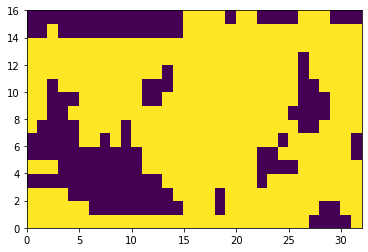

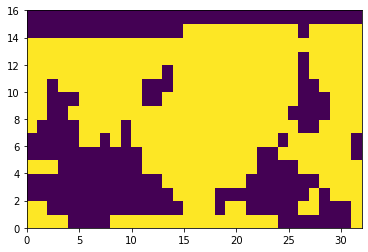

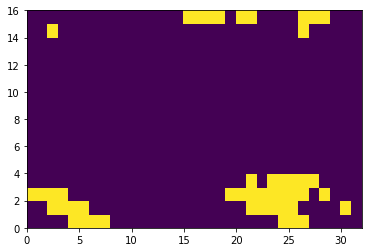

[-1.87393398e+05+0.00000000e+00j  4.67671386e+05+0.00000000e+00j
 -2.87237433e+04-1.43472284e+05j -5.00908190e+05+0.00000000e+00j
  3.12478814e+04+2.34371420e+05j  7.41041136e+04+1.95963960e+04j
  1.91178943e+05+0.00000000e+00j -2.11924804e+04-3.15280896e+05j
 -1.44804929e+05-5.64255980e+04j -4.04338304e+03+4.91184895e+04j
 -1.16080410e+05+0.00000000e+00j  2.57917627e+04+2.67462501e+05j
  2.06096552e+05+7.70155605e+04j  1.96722384e+04-8.26486098e+04j
 -7.10786274e+03+1.97671513e+04j -2.12977333e+05+0.00000000e+00j
 -2.77184020e+04-1.86646284e+05j -2.20173043e+05-1.01096611e+05j
 -3.53531392e+04+1.44305000e+05j  4.57223396e+04-5.29496665e+03j
 -9.79045541e+02+5.00476418e+03j  1.67358481e+05+0.00000000e+00j
  2.62544710e+04+1.84355542e+04j  1.90193846e+05+1.33660639e+05j
  5.47214339e+04-1.90258265e+05j -5.88479918e+04+1.14979301e+04j
  2.52900932e+03+8.28869853e+03j  1.80108528e+03+1.65669014e+02j
 -2.96185346e+05+0.00000000e+00j -1.24840487e+04+6.79612421e+04j
 -1.14241628e+05-1.373308

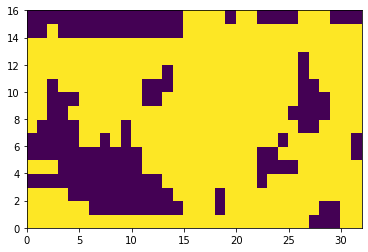

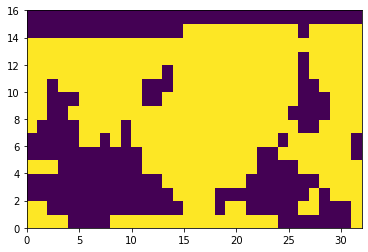

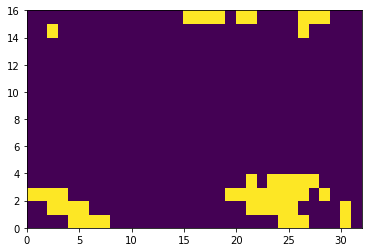

[-1.91444572e+05+0.00000000e+00j  4.76447791e+05+0.00000000e+00j
 -2.97947575e+04-1.44231071e+05j -5.11802637e+05+0.00000000e+00j
  3.33557281e+04+2.36100516e+05j  7.41068198e+04+1.93832202e+04j
  2.01781061e+05+0.00000000e+00j -2.40977278e+04-3.17906377e+05j
 -1.44657953e+05-5.59743700e+04j -4.07542943e+03+4.91699048e+04j
 -1.27483274e+05+0.00000000e+00j  2.96773003e+04+2.71148975e+05j
  2.05779054e+05+7.60929002e+04j  1.98450935e+04-8.25083582e+04j
 -7.11053763e+03+1.98938404e+04j -2.03254526e+05+0.00000000e+00j
 -3.23983566e+04-1.90901239e+05j -2.19520622e+05-9.95194090e+04j
 -3.55862653e+04+1.44067244e+05j  4.59135876e+04-5.18084018e+03j
 -9.42492688e+02+5.08764293e+03j  1.57691793e+05+0.00000000e+00j
  3.14718019e+04+2.34231203e+04j  1.89239297e+05+1.31580319e+05j
  5.50333699e+04-1.89725277e+05j -5.89608740e+04+1.12568168e+04j
  2.44150518e+03+8.33790815e+03j  1.82599360e+03+1.77469026e+02j
 -2.88469739e+05+0.00000000e+00j -1.78668597e+04+6.26609938e+04j
 -1.12940647e+05-1.344599

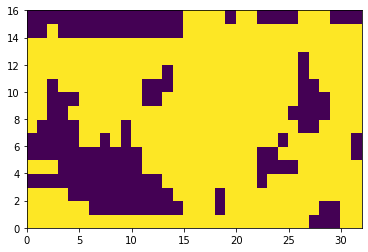

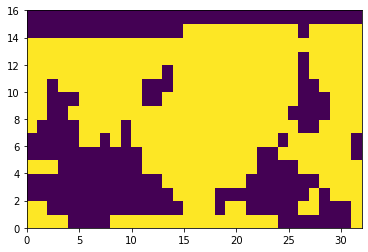

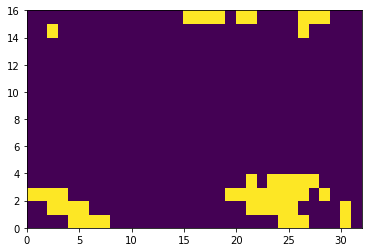

[-1.92738237e+05+0.00000000e+00j  4.80582338e+05+0.00000000e+00j
 -3.02988551e+04-1.44630903e+05j -5.16919990e+05+0.00000000e+00j
  3.43411595e+04+2.36882027e+05j  7.42257197e+04+1.92796064e+04j
  2.06198889e+05+0.00000000e+00j -2.53033134e+04-3.18967352e+05j
 -1.44733472e+05-5.58031076e+04j -4.07392144e+03+4.92634840e+04j
 -1.32561447e+05+0.00000000e+00j  3.12470313e+04+2.72646541e+05j
  2.05853784e+05+7.57527248e+04j  1.99251624e+04-8.24993823e+04j
 -7.12592680e+03+2.00101173e+04j -1.99363406e+05+0.00000000e+00j
 -3.43918168e+04-1.92278708e+05j -2.19429950e+05-9.88797495e+04j
 -3.56366863e+04+1.44086000e+05j  4.60766485e+04-5.08404905e+03j
 -9.33802160e+02+5.13026123e+03j  1.53275596e+05+0.00000000e+00j
  3.37480779e+04+2.50492108e+04j  1.89007552e+05+1.30929602e+05j
  5.50720635e+04-1.89672177e+05j -5.90613227e+04+1.11553579e+04j
  2.37236230e+03+8.43335619e+03j  1.85924869e+03+2.00172184e+02j
 -2.84996732e+05+0.00000000e+00j -2.03871819e+04+6.11632584e+04j
 -1.12355136e+05-1.334596

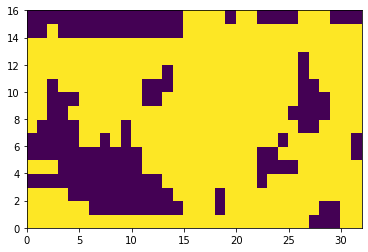

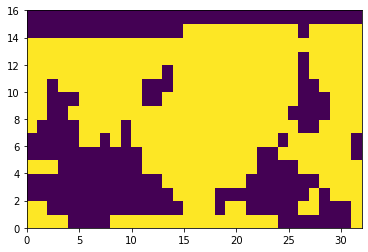

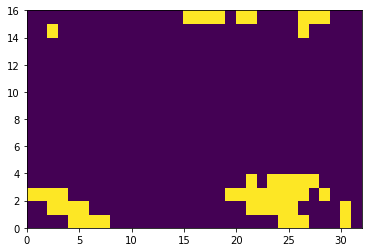

[-1.92738237e+05+0.00000000e+00j  4.81699857e+05+0.00000000e+00j
 -3.04667613e+04-1.44767134e+05j -5.18556641e+05+0.00000000e+00j
  3.46614908e+04+2.37231638e+05j  7.43073607e+04+1.92514009e+04j
  2.07011541e+05+0.00000000e+00j -2.56016203e+04-3.19338058e+05j
 -1.44830420e+05-5.57760312e+04j -4.07311261e+03+4.93040417e+04j
 -1.33935094e+05+0.00000000e+00j  3.16147399e+04+2.73276417e+05j
  2.06014477e+05+7.56635905e+04j  1.99724691e+04-8.24909184e+04j
 -7.12332743e+03+2.00670328e+04j -1.99017125e+05+0.00000000e+00j
 -3.48585840e+04-1.92658360e+05j -2.19522258e+05-9.86514425e+04j
 -3.56823006e+04+1.44133349e+05j  4.61734123e+04-5.00516127e+03j
 -9.23042313e+02+5.18078864e+03j  1.52344497e+05+0.00000000e+00j
  3.42837457e+04+2.55052089e+04j  1.89054113e+05+1.30781127e+05j
  5.51218295e+04-1.89691211e+05j -5.91379093e+04+1.10700266e+04j
  2.32419425e+03+8.48474608e+03j  1.86046227e+03+2.27135527e+02j
 -2.84799759e+05+0.00000000e+00j -2.09127204e+04+6.09721597e+04j
 -1.12204304e+05-1.331594

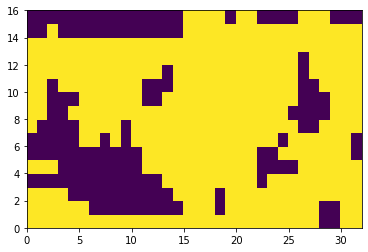

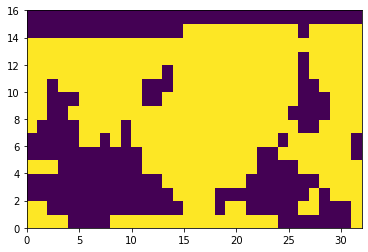

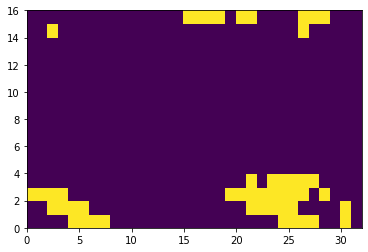

[-1.92738237e+05+0.00000000e+00j  4.82534544e+05+0.00000000e+00j
 -3.06103560e+04-1.44803573e+05j -5.20743397e+05+0.00000000e+00j
  3.48301160e+04+2.37572468e+05j  7.44053251e+04+1.92589466e+04j
  2.07859317e+05+0.00000000e+00j -2.58152209e+04-3.19573577e+05j
 -1.44958911e+05-5.58160293e+04j -4.07455038e+03+4.93652648e+04j
 -1.36313651e+05+0.00000000e+00j  3.18274851e+04+2.74041307e+05j
  2.06266002e+05+7.56905051e+04j  2.00363130e+04-8.25054254e+04j
 -7.12443866e+03+2.01416082e+04j -1.98119647e+05+0.00000000e+00j
 -3.52866891e+04-1.93089265e+05j -2.19685525e+05-9.84652261e+04j
 -3.57392016e+04+1.44221975e+05j  4.62936757e+04-4.93212444e+03j
 -9.13736850e+02+5.23894116e+03j  1.50124809e+05+0.00000000e+00j
  3.47713615e+04+2.63524181e+04j  1.89271011e+05+1.30779387e+05j
  5.51941787e+04-1.89762868e+05j -5.92336134e+04+1.09849278e+04j
  2.27374729e+03+8.53805284e+03j  1.85971041e+03+2.51715098e+02j
 -2.83595420e+05+0.00000000e+00j -2.15364483e+04+6.04127291e+04j
 -1.12164888e+05-1.328612

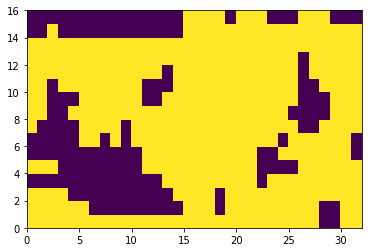

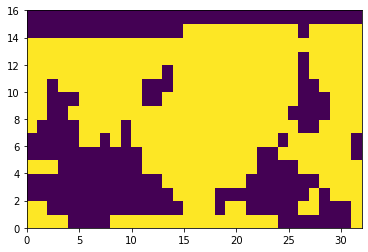

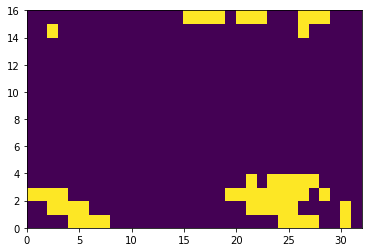

[-1.93863662e+05+0.00000000e+00j  4.80622330e+05+0.00000000e+00j
 -3.07993344e+04-1.45187627e+05j -5.28418509e+05+0.00000000e+00j
  3.54886878e+04+2.37103131e+05j  7.46216265e+04+1.93147289e+04j
  2.04370836e+05+0.00000000e+00j -2.55863112e+04-3.21326826e+05j
 -1.45058043e+05-5.58296472e+04j -4.06258695e+03+4.95448988e+04j
 -1.45500237e+05+0.00000000e+00j  3.30666811e+04+2.73168665e+05j
  2.06858525e+05+7.58607499e+04j  2.01056152e+04-8.24973880e+04j
 -7.08968244e+03+2.03456452e+04j -2.02250975e+05+0.00000000e+00j
 -3.50146435e+04-1.96551152e+05j -2.19544513e+05-9.77205717e+04j
 -3.58498002e+04+1.44319453e+05j  4.65231331e+04-4.82713921e+03j
 -8.83833644e+02+5.35467752e+03j  1.40656346e+05+0.00000000e+00j
  3.69719796e+04+2.45845737e+04j  1.90107873e+05+1.31064163e+05j
  5.50571008e+04-1.89782750e+05j -5.93323924e+04+1.08629533e+04j
  2.17204783e+03+8.60481504e+03j  1.86554695e+03+2.78086085e+02j
 -2.87531299e+05+0.00000000e+00j -2.10848171e+04+5.54314214e+04j
 -1.11334369e+05-1.314653

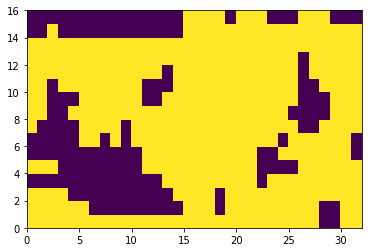

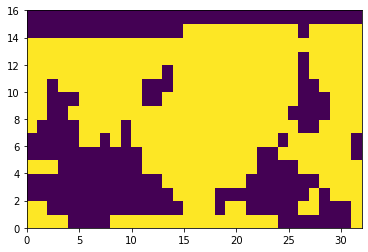

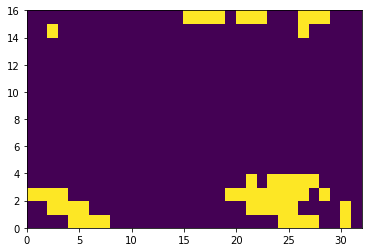

[-1.96715910e+05+0.00000000e+00j  4.77089969e+05+0.00000000e+00j
 -3.06002078e+04-1.45633735e+05j -5.33379901e+05+0.00000000e+00j
  3.57230357e+04+2.36725363e+05j  7.46898797e+04+1.93576577e+04j
  1.99764699e+05+0.00000000e+00j -2.52158515e+04-3.22566703e+05j
 -1.45001714e+05-5.56905937e+04j -4.08201250e+03+4.94854519e+04j
 -1.50874327e+05+0.00000000e+00j  3.36092277e+04+2.71860418e+05j
  2.07220036e+05+7.61597539e+04j  2.00609526e+04-8.25551835e+04j
 -7.14215261e+03+2.02665181e+04j -2.07196728e+05+0.00000000e+00j
 -3.42987437e+04-1.98686015e+05j -2.19271792e+05-9.74257724e+04j
 -3.59167044e+04+1.44415510e+05j  4.64858208e+04-4.81602387e+03j
 -9.16330468e+02+5.37019823e+03j  1.35487097e+05+0.00000000e+00j
  3.79107972e+04+2.21156487e+04j  1.90814136e+05+1.31754222e+05j
  5.50520422e+04-1.89826523e+05j -5.93706471e+04+1.08216327e+04j
  2.17329204e+03+8.62803449e+03j  1.85845368e+03+3.28645018e+02j
 -2.92224405e+05+0.00000000e+00j -2.00369579e+04+5.23046197e+04j
 -1.10551006e+05-1.308844

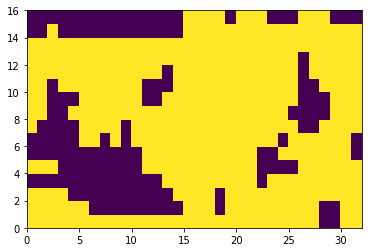

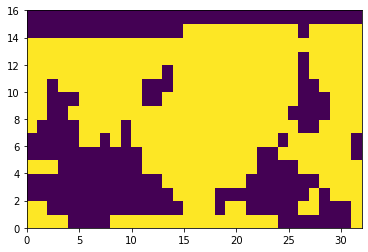

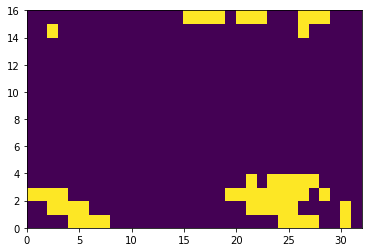

[-1.96715910e+05+0.00000000e+00j  4.76702336e+05+0.00000000e+00j
 -3.05913934e+04-1.45719490e+05j -5.34204446e+05+0.00000000e+00j
  3.57891584e+04+2.36724480e+05j  7.47592345e+04+1.94057154e+04j
  1.99378132e+05+0.00000000e+00j -2.51219101e+04-3.22802834e+05j
 -1.45111744e+05-5.57441215e+04j -4.08229864e+03+4.95313268e+04j
 -1.51393866e+05+0.00000000e+00j  3.36806216e+04+2.71801664e+05j
  2.07409222e+05+7.62479983e+04j  2.00901243e+04-8.26085844e+04j
 -7.15432590e+03+2.03023012e+04j -2.07551092e+05+0.00000000e+00j
 -3.42117324e+04-1.98969801e+05j -2.19387022e+05-9.74161334e+04j
 -3.59579034e+04+1.44496877e+05j  4.65557537e+04-4.78592888e+03j
 -8.99301121e+02+5.39568689e+03j  1.35116961e+05+0.00000000e+00j
  3.80625115e+04+2.19182347e+04j  1.90931886e+05+1.31857456e+05j
  5.50727740e+04-1.89929415e+05j -5.94422760e+04+1.07842624e+04j
  2.13915865e+03+8.66139041e+03j  1.87021435e+03+3.34787801e+02j
 -2.92458629e+05+0.00000000e+00j -1.99754617e+04+5.20961052e+04j
 -1.10473366e+05-1.308741

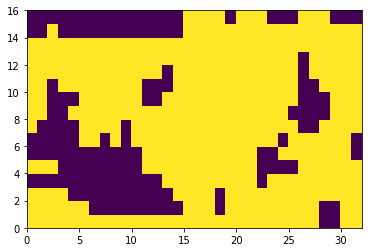

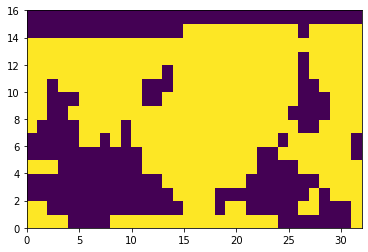

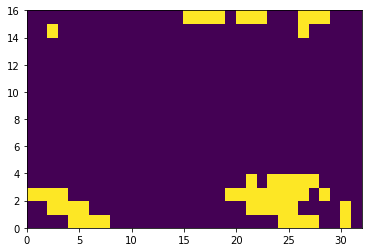

[-1.96715910e+05+0.00000000e+00j  4.76655257e+05+0.00000000e+00j
 -3.05690825e+04-1.45759433e+05j -5.34471106e+05+0.00000000e+00j
  3.57692439e+04+2.36806640e+05j  7.48116088e+04+1.94368766e+04j
  1.99236208e+05+0.00000000e+00j -2.50725092e+04-3.22896650e+05j
 -1.45203516e+05-5.57895561e+04j -4.08549424e+03+4.95601322e+04j
 -1.51583382e+05+0.00000000e+00j  3.36619537e+04+2.71849180e+05j
  2.07539353e+05+7.63224094e+04j  2.01140900e+04-8.26651643e+04j
 -7.17267847e+03+2.03103859e+04j -2.07793641e+05+0.00000000e+00j
 -3.41559674e+04-1.99024377e+05j -2.19499601e+05-9.74660553e+04j
 -3.59889459e+04+1.44587147e+05j  4.66014911e+04-4.76714948e+03j
 -8.92223366e+02+5.39945419e+03j  1.34954534e+05+0.00000000e+00j
  3.80790592e+04+2.18470579e+04j  1.91008541e+05+1.31973021e+05j
  5.51138274e+04-1.90030305e+05j -5.95036588e+04+1.07653440e+04j
  2.11802049e+03+8.69229243e+03j  1.87976589e+03+3.38258376e+02j
 -2.92631116e+05+0.00000000e+00j -1.99419582e+04+5.21196251e+04j
 -1.10448655e+05-1.309371

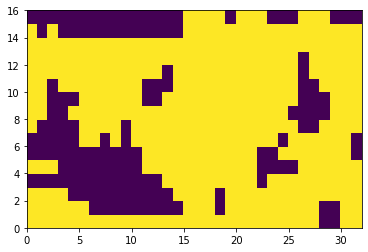

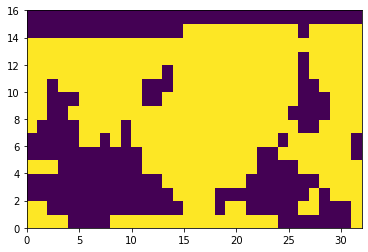

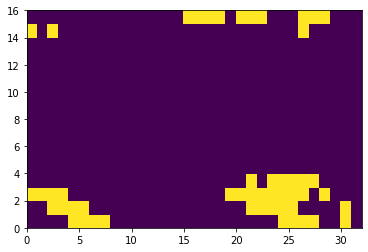

[-1.96715910e+05+0.00000000e+00j  4.75255736e+05+0.00000000e+00j
 -3.10283808e+04-1.45722011e+05j -5.36453433e+05+0.00000000e+00j
  3.49744050e+04+2.36824996e+05j  7.47604107e+04+1.94729946e+04j
  1.97351150e+05+0.00000000e+00j -2.62373071e+04-3.22890989e+05j
 -1.45683438e+05-5.59131261e+04j -4.12737967e+03+4.96550286e+04j
 -1.53240586e+05+0.00000000e+00j  3.20074118e+04+2.71925977e+05j
  2.07079248e+05+7.63942676e+04j  2.00288322e+04-8.27045037e+04j
 -7.18449496e+03+2.04013490e+04j -2.09079937e+05+0.00000000e+00j
 -3.59750516e+04-1.99038119e+05j -2.20609118e+05-9.74755345e+04j
 -3.63234695e+04+1.44671863e+05j  4.66656649e+04-4.72191011e+03j
 -8.80595142e+02+5.44293735e+03j  1.34304970e+05+0.00000000e+00j
  3.61534380e+04+2.18438765e+04j  1.89759378e+05+1.32049879e+05j
  5.46369459e+04-1.90127820e+05j -5.96973212e+04+1.07243356e+04j
  2.04688252e+03+8.73080324e+03j  1.88851106e+03+3.44468865e+02j
 -2.92598509e+05+0.00000000e+00j -2.17764636e+04+5.21924170e+04j
 -1.12047186e+05-1.309655

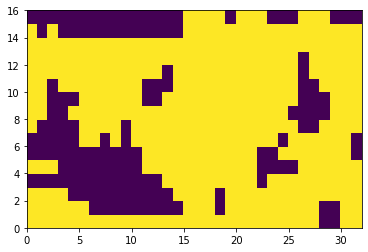

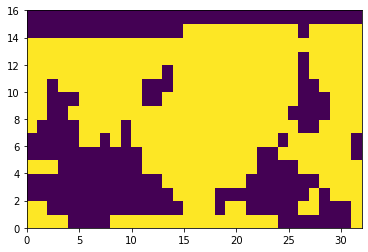

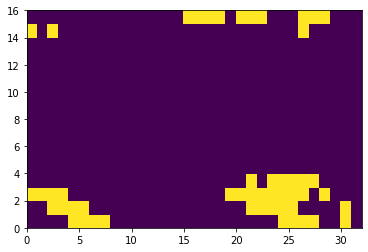

[-1.97754521e+05+0.00000000e+00j  4.74474141e+05+0.00000000e+00j
 -3.11670760e+04-1.45777859e+05j -5.37501510e+05+0.00000000e+00j
  3.44818717e+04+2.36973519e+05j  7.46874012e+04+1.94650836e+04j
  1.96635308e+05+0.00000000e+00j -2.68513708e+04-3.22999371e+05j
 -1.45896278e+05-5.58993020e+04j -4.17860571e+03+4.96062185e+04j
 -1.54014355e+05+0.00000000e+00j  3.13187007e+04+2.72022843e+05j
  2.06864802e+05+7.64523840e+04j  1.99296276e+04-8.27535302e+04j
 -7.23045931e+03+2.03386704e+04j -2.09492174e+05+0.00000000e+00j
 -3.67799627e+04-1.99117529e+05j -2.21139027e+05-9.75057080e+04j
 -3.64546898e+04+1.44759616e+05j  4.66008292e+04-4.72465078e+03j
 -8.94562598e+02+5.43681125e+03j  1.34024625e+05+0.00000000e+00j
  3.54219865e+04+2.18110045e+04j  1.89248990e+05+1.32144949e+05j
  5.44385822e+04-1.90169511e+05j -5.97771696e+04+1.07380386e+04j
  2.02953783e+03+8.74104213e+03j  1.88792916e+03+3.69025666e+02j
 -2.92586421e+05+0.00000000e+00j -2.25576095e+04+5.21459369e+04j
 -1.12750425e+05-1.309685

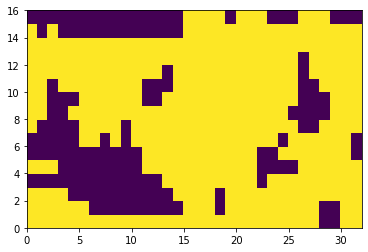

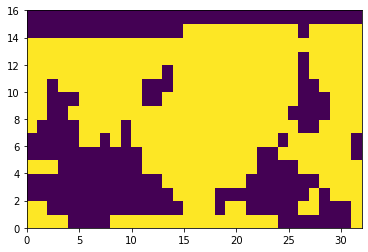

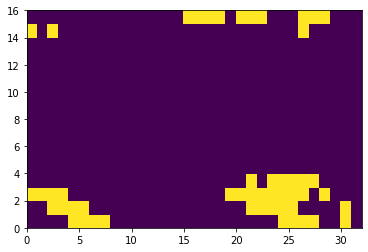

[-1.97754521e+05+0.00000000e+00j  4.74386904e+05+0.00000000e+00j
 -3.12075138e+04-1.45793052e+05j -5.37813108e+05+0.00000000e+00j
  3.43580754e+04+2.37056775e+05j  7.47172239e+04+1.94794746e+04j
  1.96483988e+05+0.00000000e+00j -2.69143047e+04-3.23049235e+05j
 -1.45996072e+05-5.59411122e+04j -4.18573582e+03+4.96340076e+04j
 -1.54234416e+05+0.00000000e+00j  3.12279029e+04+2.72105195e+05j
  2.06940053e+05+7.65035901e+04j  1.99351589e+04-8.28011927e+04j
 -7.24456483e+03+2.03488376e+04j -2.09671138e+05+0.00000000e+00j
 -3.68350647e+04-1.99144690e+05j -2.21276833e+05-9.75308786e+04j
 -3.64820613e+04+1.44829678e+05j  4.66361165e+04-4.71364697e+03j
 -8.89704194e+02+5.43875704e+03j  1.33871910e+05+0.00000000e+00j
  3.53942197e+04+2.18110584e+04j  1.89266212e+05+1.32212032e+05j
  5.44429945e+04-1.90243165e+05j -5.98260353e+04+1.07202573e+04j
  2.00868421e+03+8.76419915e+03j  1.89694635e+03+3.70612774e+02j
 -2.92677027e+05+0.00000000e+00j -2.26085361e+04+5.21766987e+04j
 -1.12775272e+05-1.309940

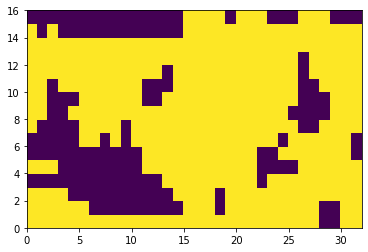

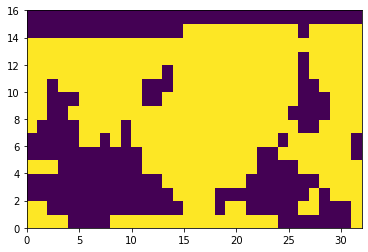

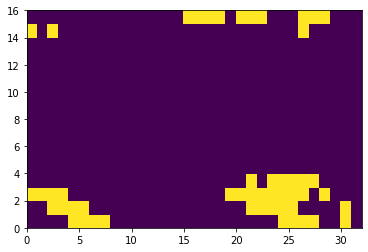

[-1.97754521e+05+0.00000000e+00j  4.74542566e+05+0.00000000e+00j
 -3.12199167e+04-1.45826101e+05j -5.38037143e+05+0.00000000e+00j
  3.43295351e+04+2.37146974e+05j  7.47536561e+04+1.94884230e+04j
  1.96584983e+05+0.00000000e+00j -2.69436846e+04-3.23144189e+05j
 -1.46070240e+05-5.59676165e+04j -4.18815377e+03+4.96562298e+04j
 -1.54426904e+05+0.00000000e+00j  3.12428129e+04+2.72192344e+05j
  2.07020491e+05+7.65277933e+04j  1.99452853e+04-8.28411399e+04j
 -7.25724521e+03+2.03561053e+04j -2.09668525e+05+0.00000000e+00j
 -3.68874227e+04-1.99232446e+05j -2.21373367e+05-9.75431292e+04j
 -3.64965503e+04+1.44888501e+05j  4.66658942e+04-4.70258719e+03j
 -8.85875440e+02+5.43976008e+03j  1.33695043e+05+0.00000000e+00j
  3.54637763e+04+2.18310097e+04j  1.89298890e+05+1.32234491e+05j
  5.44525935e+04-1.90306451e+05j -5.98658860e+04+1.07077821e+04j
  1.99184788e+03+8.78643595e+03j  1.90446521e+03+3.72221687e+02j
 -2.92674492e+05+0.00000000e+00j -2.26919939e+04+5.21347094e+04j
 -1.12772558e+05-1.309941

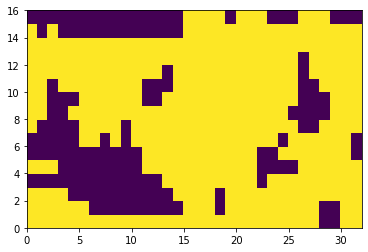

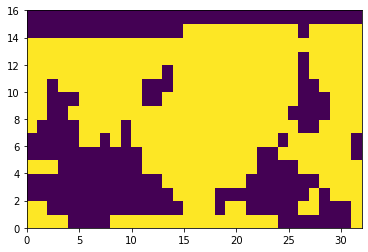

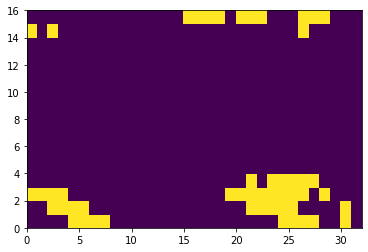

[-1.97754521e+05+0.00000000e+00j  4.74671031e+05+0.00000000e+00j
 -3.12184919e+04-1.45858664e+05j -5.38210605e+05+0.00000000e+00j
  3.43112568e+04+2.37228023e+05j  7.47888649e+04+1.94944081e+04j
  1.96630985e+05+0.00000000e+00j -2.69484816e+04-3.23225695e+05j
 -1.46135316e+05-5.59884152e+04j -4.19014207e+03+4.96736156e+04j
 -1.54562708e+05+0.00000000e+00j  3.12436524e+04+2.72259037e+05j
  2.07094295e+05+7.65538159e+04j  1.99558769e+04-8.28761749e+04j
 -7.27067524e+03+2.03635429e+04j -2.09732332e+05+0.00000000e+00j
 -3.69033596e+04-1.99291874e+05j -2.21460755e+05-9.75606086e+04j
 -3.65093175e+04+1.44942946e+05j  4.66925847e+04-4.69271794e+03j
 -8.83589235e+02+5.44085643e+03j  1.33565403e+05+0.00000000e+00j
  3.55003573e+04+2.18217036e+04j  1.89332037e+05+1.32271410e+05j
  5.44674867e+04-1.90364447e+05j -5.99038753e+04+1.06958654e+04j
  1.97836345e+03+8.80885486e+03j  1.91165279e+03+3.73491428e+02j
 -2.92737971e+05+0.00000000e+00j -2.27276344e+04+5.21269547e+04j
 -1.12773666e+05-1.310110

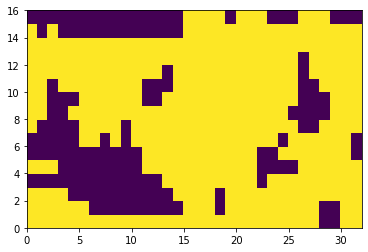

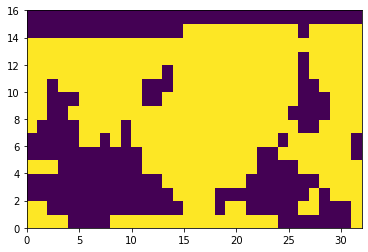

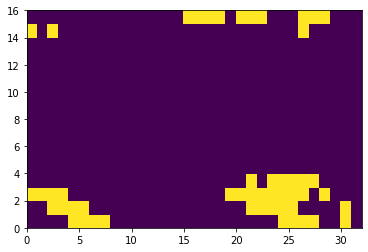

[-1.97754521e+05+0.00000000e+00j  4.74774188e+05+0.00000000e+00j
 -3.12149263e+04-1.45891761e+05j -5.38341032e+05+0.00000000e+00j
  3.43002895e+04+2.37309464e+05j  7.48224217e+04+1.94973949e+04j
  1.96645313e+05+0.00000000e+00j -2.69521994e+04-3.23307065e+05j
 -1.46196117e+05-5.60009234e+04j -4.19110948e+03+4.96877255e+04j
 -1.54639666e+05+0.00000000e+00j  3.12451949e+04+2.72326976e+05j
  2.07164109e+05+7.65697880e+04j  1.99638958e+04-8.29067881e+04j
 -7.28348878e+03+2.03701305e+04j -2.09842445e+05+0.00000000e+00j
 -3.69134350e+04-1.99349662e+05j -2.21543290e+05-9.75655313e+04j
 -3.65164821e+04+1.44989715e+05j  4.67150727e+04-4.68408008e+03j
 -8.81620714e+02+5.44137245e+03j  1.33513858e+05+0.00000000e+00j
  3.55257286e+04+2.18149178e+04j  1.89366034e+05+1.32290822e+05j
  5.44760649e+04-1.90412396e+05j -5.99366091e+04+1.06854102e+04j
  1.96618233e+03+8.83005148e+03j  1.91844718e+03+3.74172198e+02j
 -2.92870233e+05+0.00000000e+00j -2.27443785e+04+5.21247561e+04j
 -1.12778582e+05-1.310101

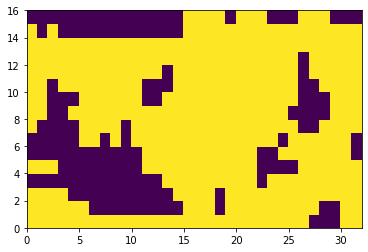

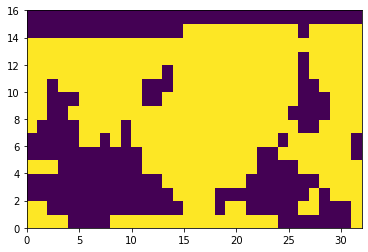

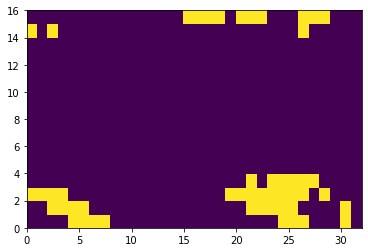

[-1.97754521e+05+0.00000000e+00j  4.73641734e+05+0.00000000e+00j
 -3.10749670e+04-1.45868132e+05j -5.36989008e+05+0.00000000e+00j
  3.41196677e+04+2.37220243e+05j  7.48140415e+04+1.95135248e+04j
  1.95062161e+05+0.00000000e+00j -2.67408463e+04-3.23071013e+05j
 -1.46195805e+05-5.60044297e+04j -4.20277670e+03+4.96505750e+04j
 -1.52906106e+05+0.00000000e+00j  3.09255503e+04+2.71869348e+05j
  2.07145115e+05+7.66730318e+04j  1.99575334e+04-8.29460025e+04j
 -7.31055974e+03+2.03117649e+04j -2.11742284e+05+0.00000000e+00j
 -3.64607994e+04-1.98733365e+05j -2.21529654e+05-9.77580927e+04j
 -3.65331121e+04+1.45036922e+05j  4.66797844e+04-4.69536740e+03j
 -8.88031991e+02+5.41217249e+03j  1.35384186e+05+0.00000000e+00j
  3.49856967e+04+2.09498289e+04j  1.89296697e+05+1.32558447e+05j
  5.45379901e+04-1.90460858e+05j -5.99588270e+04+1.06927732e+04j
  1.97776964e+03+8.84067246e+03j  1.92224558e+03+3.73092750e+02j
 -2.94814284e+05+0.00000000e+00j -2.20827651e+04+5.30980496e+04j
 -1.12668793e+05-1.313576

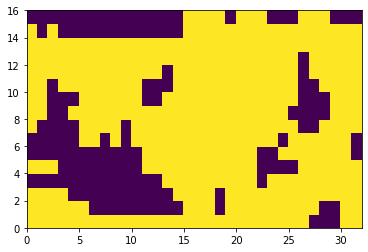

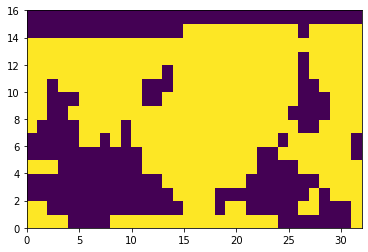

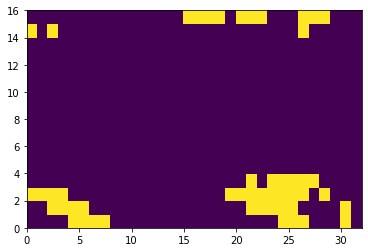

[-1.96629096e+05+0.00000000e+00j  4.71934181e+05+0.00000000e+00j
 -3.09783456e+04-1.45723510e+05j -5.34862044e+05+0.00000000e+00j
  3.38953273e+04+2.36945860e+05j  7.48247451e+04+1.95585749e+04j
  1.92568901e+05+0.00000000e+00j -2.63819956e+04-3.22570686e+05j
 -1.46216875e+05-5.61111082e+04j -4.20865335e+03+4.96717263e+04j
 -1.50291672e+05+0.00000000e+00j  3.04108382e+04+2.71157081e+05j
  2.07159974e+05+7.68363291e+04j  1.99859179e+04-8.29838097e+04j
 -7.32020546e+03+2.03210552e+04j -2.14598714e+05+0.00000000e+00j
 -3.57877969e+04-1.97782759e+05j -2.21517390e+05-9.79976379e+04j
 -3.65797163e+04+1.45091064e+05j  4.67104005e+04-4.68981855e+03j
 -8.83790534e+02+5.42285624e+03j  1.38093028e+05+0.00000000e+00j
  3.41684360e+04+1.97330507e+04j  1.89207330e+05+1.32908502e+05j
  5.46018992e+04-1.90524314e+05j -5.99989637e+04+1.06855641e+04j
  1.96538255e+03+8.84933644e+03j  1.92756200e+03+3.77998445e+02j
 -2.97607631e+05+0.00000000e+00j -2.11149571e+04+5.45402589e+04j
 -1.12501991e+05-1.318205

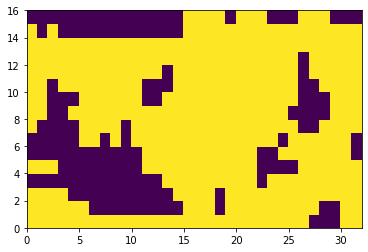

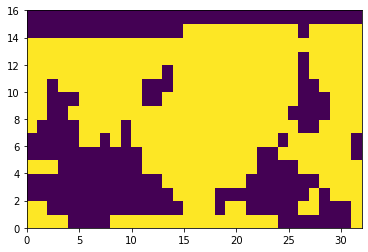

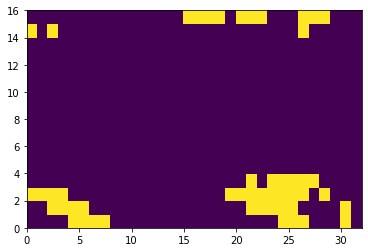

[-1.96629096e+05+0.00000000e+00j  4.71683003e+05+0.00000000e+00j
 -3.09409090e+04-1.45709731e+05j -5.34626179e+05+0.00000000e+00j
  3.38361462e+04+2.36967068e+05j  7.48411755e+04+1.95662598e+04j
  1.92313650e+05+0.00000000e+00j -2.63483047e+04-3.22547975e+05j
 -1.46260541e+05-5.61227501e+04j -4.21140190e+03+4.96661077e+04j
 -1.50085370e+05+0.00000000e+00j  3.03692611e+04+2.71107274e+05j
  2.07209849e+05+7.68659729e+04j  1.99880910e+04-8.30107541e+04j
 -7.33504752e+03+2.03060760e+04j -2.14878670e+05+0.00000000e+00j
 -3.57386382e+04-1.97726708e+05j -2.21577506e+05-9.80290164e+04j
 -3.65842132e+04+1.45125672e+05j  4.67099016e+04-4.68834268e+03j
 -8.83990331e+02+5.41520014e+03j  1.38258531e+05+0.00000000e+00j
  3.41405983e+04+1.96199753e+04j  1.89226378e+05+1.32941322e+05j
  5.46170306e+04-1.90556078e+05j -6.00203586e+04+1.06817733e+04j
  1.96024876e+03+8.86336055e+03j  1.92903731e+03+3.76528243e+02j
 -2.97870313e+05+0.00000000e+00j -2.10799323e+04+5.46356555e+04j
 -1.12498517e+05-1.318445

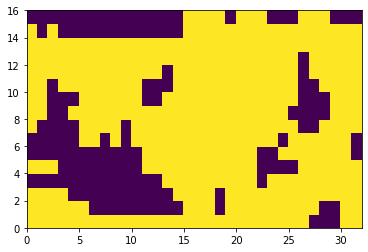

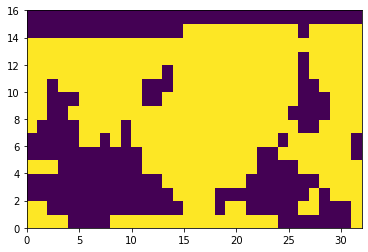

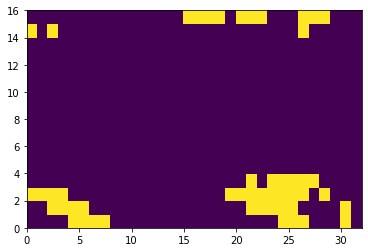

[-1.96629096e+05+0.00000000e+00j  4.71682353e+05+0.00000000e+00j
 -3.09323354e+04-1.45720237e+05j -5.34651669e+05+0.00000000e+00j
  3.38184025e+04+2.37017514e+05j  7.48604287e+04+1.95728968e+04j
  1.92275819e+05+0.00000000e+00j -2.63403982e+04-3.22585549e+05j
 -1.46299925e+05-5.61374763e+04j -4.21205455e+03+4.96725826e+04j
 -1.50078241e+05+0.00000000e+00j  3.03611894e+04+2.71134796e+05j
  2.07257914e+05+7.68859323e+04j  1.99942887e+04-8.30341083e+04j
 -7.34318477e+03+2.03055048e+04j -2.14986708e+05+0.00000000e+00j
 -3.57305453e+04-1.97743279e+05j -2.21633439e+05-9.80475889e+04j
 -3.65927103e+04+1.45159314e+05j  4.67215026e+04-4.68353519e+03j
 -8.82360123e+02+5.41590708e+03j  1.38259865e+05+0.00000000e+00j
  3.41481802e+04+1.95918179e+04j  1.89249443e+05+1.32966581e+05j
  5.46285727e+04-1.90592371e+05j -6.00436201e+04+1.06756846e+04j
  1.95319563e+03+8.87493455e+03j  1.93152693e+03+3.77351385e+02j
 -2.97980649e+05+0.00000000e+00j -2.10834719e+04+5.46605880e+04j
 -1.12500301e+05-1.318623

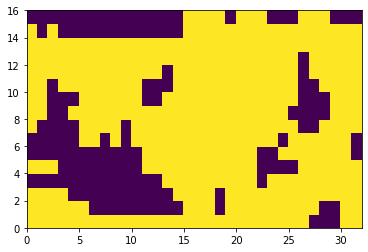

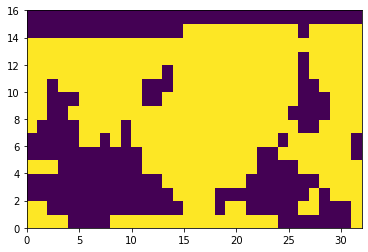

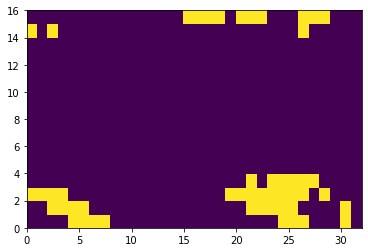

Topo_Loop: 100%|██████████| 1/1 [00:24<00:00, 24.75s/it]

[-1.96629096e+05+0.00000000e+00j  4.71724650e+05+0.00000000e+00j
 -3.09308028e+04-1.45736195e+05j -5.34724626e+05+0.00000000e+00j
  3.38097414e+04+2.37072091e+05j  7.48795609e+04+1.95779794e+04j
  1.92267787e+05+0.00000000e+00j -2.63344046e+04-3.22632663e+05j
 -1.46335923e+05-5.61515054e+04j -4.21187712e+03+4.96810136e+04j
 -1.50090122e+05+0.00000000e+00j  3.03568635e+04+2.71172686e+05j
  2.07301961e+05+7.69027975e+04j  2.00007346e+04-8.30539642e+04j
 -7.34906914e+03+2.03085248e+04j -2.15071449e+05+0.00000000e+00j
 -3.57271632e+04-1.97767539e+05j -2.21684242e+05-9.80634151e+04j
 -3.66012710e+04+1.45189836e+05j  4.67347008e+04-4.67813648e+03j
 -8.80604564e+02+5.41843557e+03j  1.38249777e+05+0.00000000e+00j
  3.41578595e+04+1.95730679e+04j  1.89271101e+05+1.32991114e+05j
  5.46388672e+04-1.90627165e+05j -6.00652941e+04+1.06692340e+04j
  1.94641582e+03+8.88528921e+03j  1.93385820e+03+3.78385273e+02j
 -2.98071211e+05+0.00000000e+00j -2.10889084e+04+5.46802651e+04j
 -1.12502364e+05-1.318812

In [150]:
for topo_it in tqdm(range(model_p.topo_it_max-1),"Topo_Loop"): # Il y a un pb sur le chargement de topo à corriger !
    topo_loop(model_p,grid,ice,sed,topo,love,oc,SL,topo_it)

In [151]:
#final treatment !:

RSL=np.zeros(topo.topo.shape)
for t_it in range(len(grid.time_step)):
    RSL[t_it,:,:]=topo.topo[-1,:,:]-ice.ice_corrected[-1,:,:]-sed.sed[-1,:,:]-(topo.topo[t_it,:,:]-ice.ice_corrected[t_it,:,:]-sed.sed[t_it,:,:])

26.0


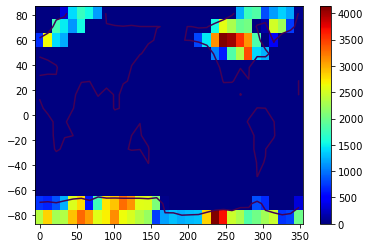

25.0


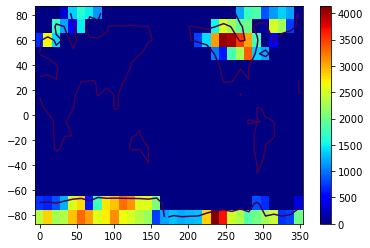

24.0


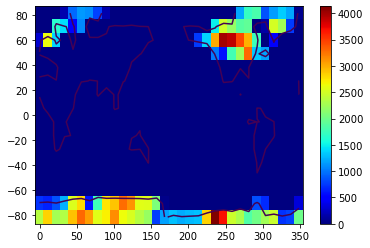

23.0


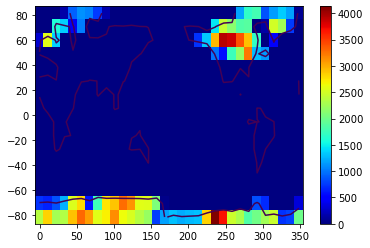

22.0


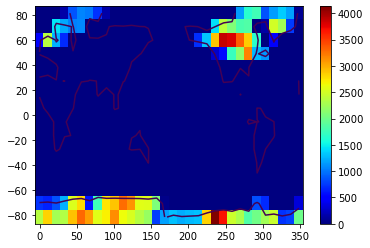

21.0


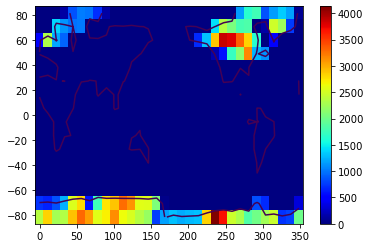

20.5


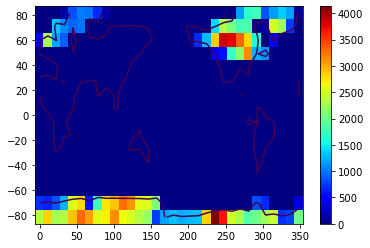

20.0


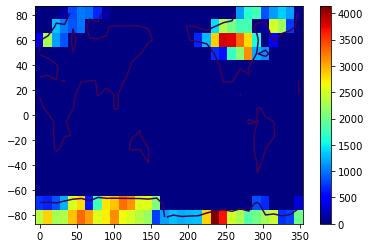

19.5


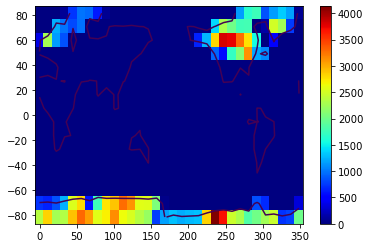

19.0


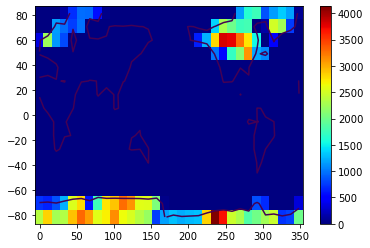

18.5


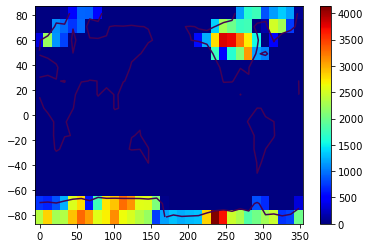

18.0


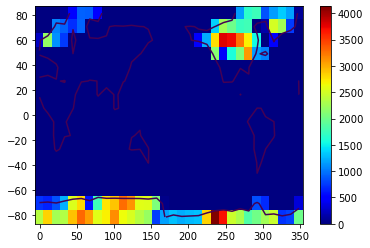

17.5


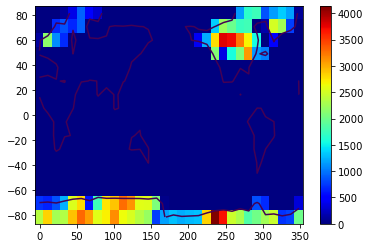

17.0


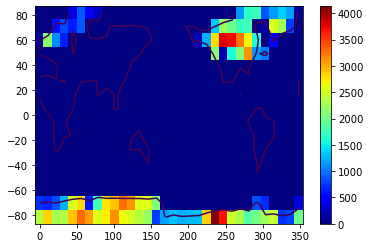

16.5


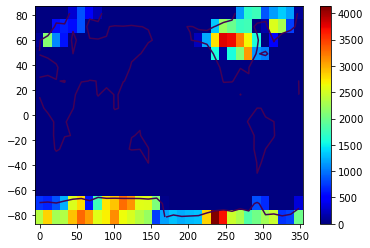

16.0


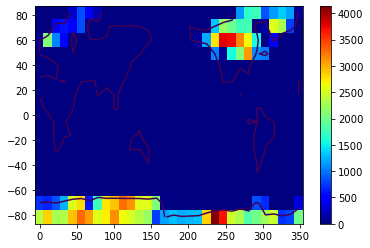

15.5


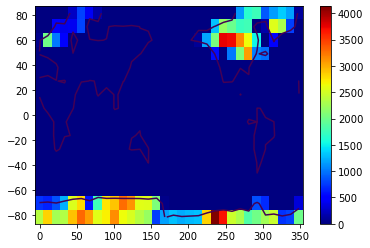

15.0


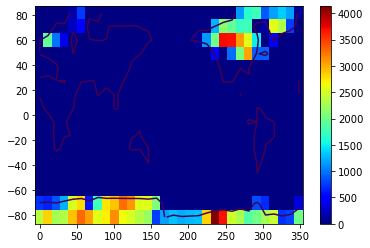

14.5


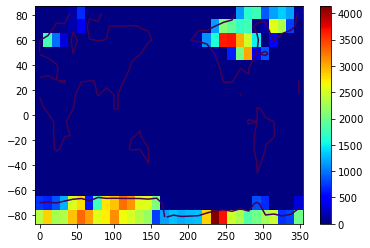

14.0


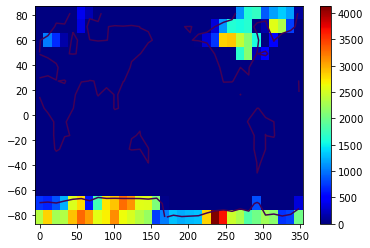

13.5


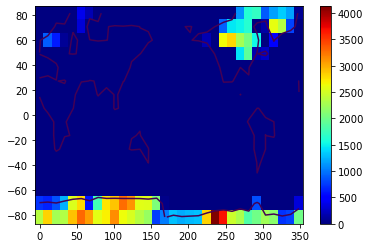

13.0


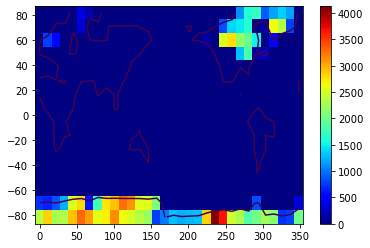

12.5


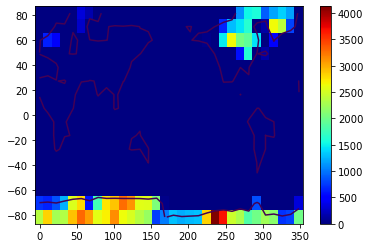

12.0


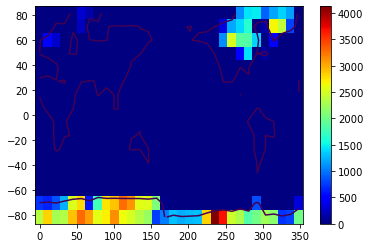

11.5


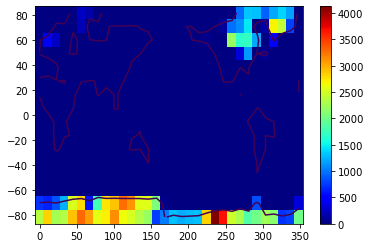

11.0


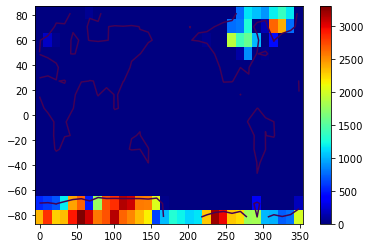

10.5


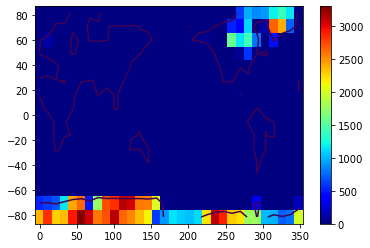

10.0


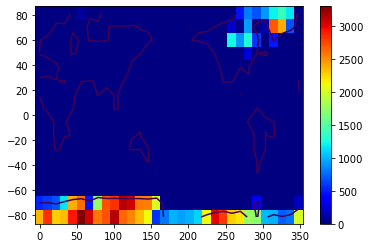

9.5


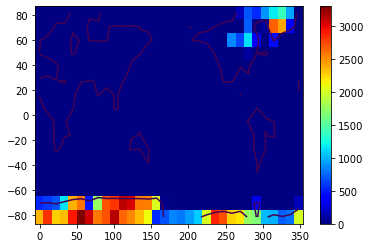

9.0


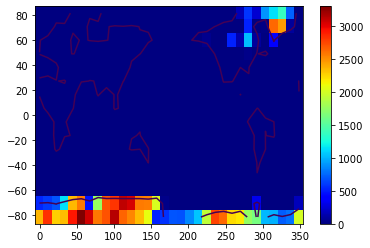

8.5


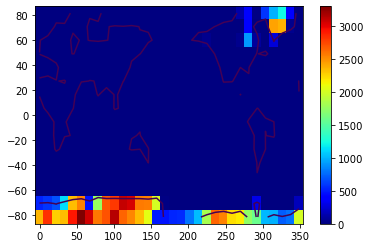

8.0


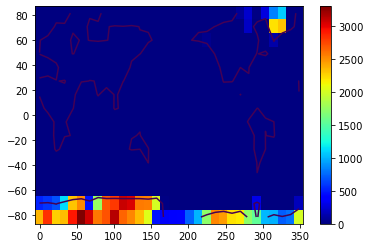

7.5


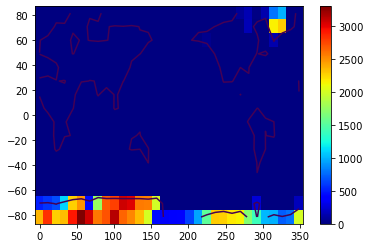

7.0


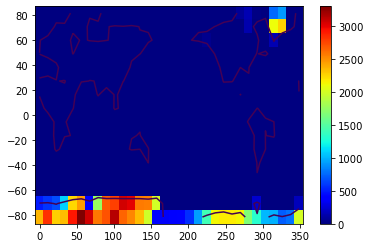

6.5


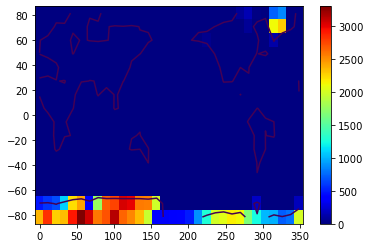

6.0


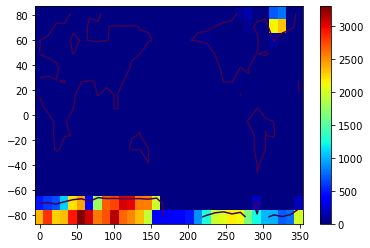

5.5


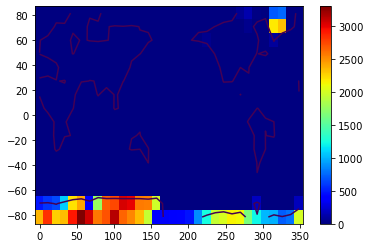

5.0


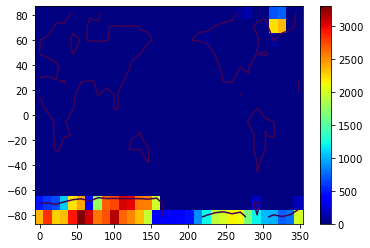

4.5


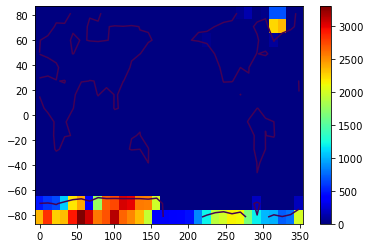

4.0


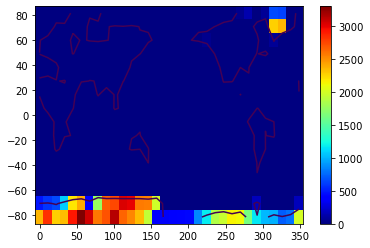

3.5


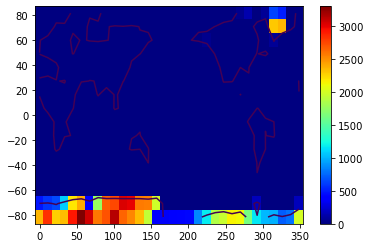

3.0


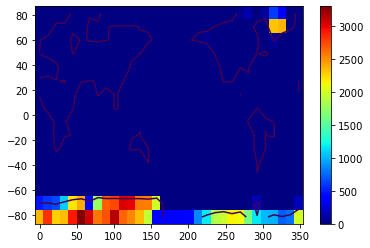

2.5


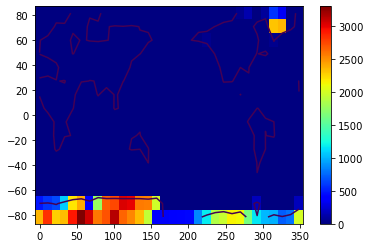

2.0


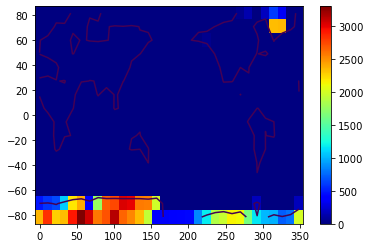

1.5


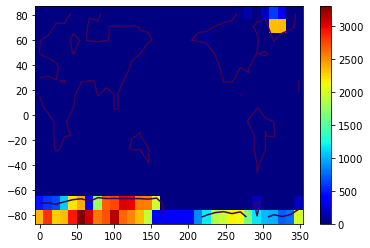

1.0


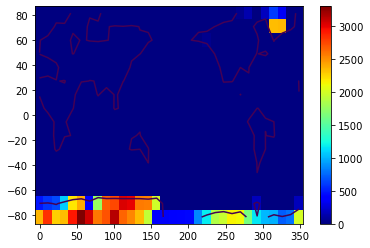

0.5


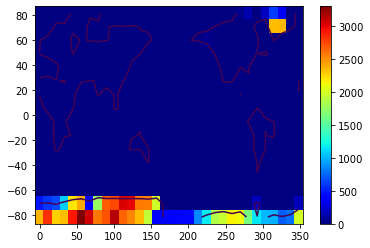

0.0


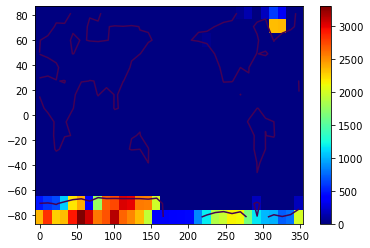

In [154]:
for i in range(len(grid.time_step)):
    print(grid.time_step[i])
    #plt.pcolor(grid.elons,grid.lats,ice.ice[i,:,:],vmin=-250, vmax=900)
    plt.pcolor(grid.elons,grid.lats,ice.ice[i,:,:],cmap='jet')
    plt.colorbar()
    plt.contour(grid.elons,grid.lats,topo.topo[i,:,:],[0])
    plt.show()

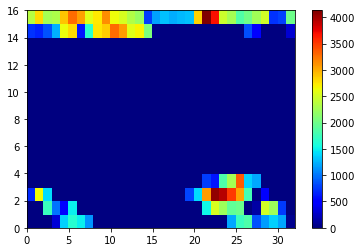

In [ ]:
plt.pcolor(ice.ice[1,:,:],cmap='jet')
plt.colorbar()

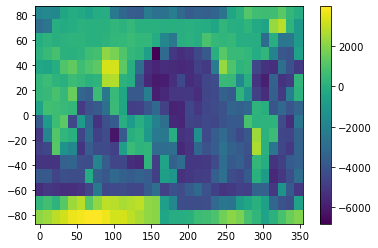

In [99]:
plt.pcolor(grid.elons,grid.lats,topo.topo_pres)
plt.colorbar()
plt.show()

In [ ]:
for i in range(len(grid.time_step)-1):
    print(grid.time_step[i])
    plt.pcolor(grid.elons,grid.lats,to_grd(SL.saved[i,:,:]))
    plt.colorbar()
    plt.show()
    time.sleep(0.1)

### Convergence criterion

In [ ]:
if chi < epsilon:
  print('Converged after iteration', k, 'Chi was', chi)
else:
  print ('Did not yet converge.')
  print ('Finished iteration', k, '; Chi was', chi)

end_time = time.time()

print ("Time elapsed in k loop", end_time - start_time)
# calculate the scaling to normalize the fingerprint (it's normalized to be
# one on average, when averaged over the final ocean basin). 
# calculate change in sea level over final ocean basin
del_scaling = (delSL + del_ice_corrected) * oc_j
# get the average of that when spreading the water over the whole globe
sca = sh.grdtospec(del_scaling, norm='unity')
# get the average of that when spreading the water only over the oceans.
scaling_fact = sca[0] / ocj_ml[0]